# EXAM

**Objective:** classify a job posting as Frauduent or Legit.
In this dataset, a job posting is a combination of all the textual columns. Thus, you need to regroup these information together. 

1. Split the train set into Training,  Validation, & Test sets (0.75, 0.15, 0.1).
2. Exploratory Data Analysis (EDA): look closely at your data, the textual columns, the target, any null values, any imbalance, non-numerical data to be converted (in data and target)?, etc.
3. Clean Textual Data
4. Vectorize Texts (one hot encoder, tfidf, embeddings, etc.)
5. Choose and justify the choice of the evaluation metric
6. ML Classification model(s) or DL model or an ensemble of several ML/DL or both ML and DL models
7. Hyperparameter tuning (Cross validation - hyperopt - Gridsearch), if you use crossvalidation, then no need to split the train set into train and validation. If you use hyperopt, you will need both sets. NB: Once you have identified the optimal hyperparameters, you must merge the train adn validation sets together and retrain the model on both datasets before predicting on the test set.
8. Evaluate on Test set (i.e., apply the cleaning, the vectorization, and the model)
9. Use Lime to explain one text classification
10. Use Shapley to explain globally the text classification

**Comment all your steps: justify your choices, analyze the results (whether positive or negative), and finally conclude by suggesting improvements and making recommendations.**

You can use one notebook for all your work or separate the EDA from the training and finally the testing and interpretability. <br>
You can also use .py scripts (classes/functions) and initialize/call them from the notebook. <br>

you will be evaluated on the problem solving skills, the methods used, and **the comments and analysis** you will provide. <br>
Organize the notebook and follow the steps as listed above, if you would like to change the order of the sections, you will need to justify the reason. <br>

**NB:**
-Imbalance can be fixed by Over/Under sampling and Data Augmentation.<br> Using Textual Data Augmentation techniques would be a bonus if used.



# **Introduction**

In this notebook, I explore the challenging problem of detecting fraudulent job postings using machine learning and natural language processing techniques. With the proliferation of online job platforms, identifying deceptive listings has become increasingly important to protect job seekers from scams that could lead to identity theft, financial loss, or wasted time pursuing non-existent opportunities.

**Table of Contents**

1. **Train, Validation, & Test split**

2. **Exploratory Data Analysis**
   - Words in fraud & non fraud posting
   - Distributions of fraudulent for each binary feature
   - Distribution of employment type, required experience
   - Fraudulent vs Non fraudulent in each country

3. **Pre-processing**
   - Make preprocessing pipeline for validation and test

4. **Sampling and data augmentation methods**

5. **Modelling (Ensemble and traditional)**

6. **Hyperparameter tuning**

7. **Interpreting model**

9. **Deep learning modelling (BERT)**

10. **BERT Interpretation**

11. **Conclusion**

As shown in the table of contents, this project follows a comprehensive approach to fraud detection, beginning with data splitting and exploratory analysis, moving through preprocessing and sampling techniques, and culminating in both traditional modeling and advanced deep learning with BERT. Each section builds upon previous findings to create a robust classification system capable of distinguishing legitimate job postings from fraudulent ones.

Throughout the notebook, I've structured my work with detailed commentary following a consistent format:
- **What the code does so far?** - Technical explanation of implementation details
- **Why do we need to do this?** - Rationale behind each approach and methodology
- **Analysis and insights** - Key findings and patterns discovered in the data
- **Things to keep in mind** - Important considerations, limitations, and potential improvements

For this project, I used the "Real or Fake Job Posting Prediction" dataset from Kaggle (https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction), which contains approximately 18,000 job postings with around 800 fraudulent examples. Due to the computational demands of transformer-based models like BERT, I executed this notebook in Kaggle's environment to leverage their GPU capabilities.

I would like to acknowledge that I utilized ChatGPT for assistance with certain code syntax optimizations and to create cleaner, more interpretable visualizations. This collaborative approach allowed me to focus on the analytical aspects while maintaining high-quality code and presentation standards.

By the conclusion of this notebook, I aim to not only build effective classification models but also provide actionable insights into the linguistic and structural patterns that differentiate legitimate job opportunities from fraudulent schemes.

In [1]:
!pip install imblearn
!pip install -U scikit-learn imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 98.2 MB/s eta 0:00:00:00:01:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


In [2]:
# Import necessary libraries

import pandas as pd
import numpy as np
import warnings
import torch
import random
# from sklearn.model_selection import train_test_split

# Ignore warnings
warnings.filterwarnings('ignore')

# Set display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

# Set all random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Essential data science modules
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

# Natural Language Toolkit (NTLK) modules


!pip install nltk stop-words
import nltk
nltk.download('stopwords')
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
nltk.download(['stopwords', 'averaged_perceptron_tagger', 'wordnet', 'punkt'])

# scikit-learn modules
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, matthews_corrcoef, confusion_matrix
from sklearn.metrics import classification_report, f1_score, fbeta_score
# from sklearn.metrics import plot_roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
import nltk
from nltk.corpus import wordnet
import random

# Other modules
# !pip install stop_words eli5 re
# from stop_words import get_stop_words
# import eli5
# import re
# from scipy import stats
# import matplotlib.gridspec as gridspec
# from wordcloud import WordCloud
# # from imblearn.under_sampling import RandomUnderSampler
# # from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
# from imblearn.pipeline import Pipeline
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import spacy
# from spacy.lang.en import English
# import gc
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.preprocessing.text import Tokenizer

Using device: cuda
  Preparing metadata (setup.py) ... done
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32894 sha256=abb588e04a68d91b036e9673aa53a5d128a3047effbc0f26fa4362ed1c43913f
  Stored in directory: /root/.cache/pip/wheels/8f/a5/51/a5405e1da5d178491b79d12cc81b6cb9bb14fe2c8c632eba70
Successfully built stop-words


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
df = pd.read_csv('/kaggle/input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv')
df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

job_id                                      title            location department salary_range                                    company_profile                                        description                                       requirements                                           benefits  telecommuting  has_company_logo  has_questions employment_type required_experience required_education                   industry              function  fraudulent
0       1                           Marketing Intern    US, NY, New York  Marketing          NaN  We're Food52, and we've created a groundbreaki...  Food52, a fast-growing, James Beard Award-winn...  Experience with content management systems a m...                                                NaN              0                 1              0           Other          Internship                NaN                        NaN             Marketing           0
1       2  Customer Service - Cloud Video Production      NZ, , Auckland    Success          NaN  90 Seconds, the worlds Cloud Video Production ...  Organised - Focused - Vibrant - Awesome!Do you...  What we expect from you:Your key responsibilit...  What you will get from usThrough being part of...              0                 1              0       Full-time      Not Applicable                NaN  Marketing and Advertising      Customer Service           0
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever        NaN          NaN  Valor Services provides Workforce Solutions th...  Our client, located in Houston, is actively se...  Implement pre-commissioning and commissioning ...                                                NaN              0                 1              0             NaN                 NaN                NaN                        NaN                   NaN           0
3       4          Account Executive - Washington DC  US, DC, Washington      Sales          NaN  Our passion for improving quality of life thro...  THE COMPANY: ESRI – Environmental Systems Rese...  EDUCATION: Bachelor’s or Master’s in GIS, busi...  Our culture is anything but corporate—we have ...              0                 1              0       Full-time    Mid-Senior level  Bachelor's Degree          Computer Software                 Sales           0
4       5                        Bill Review Manager  US, FL, Fort Worth        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...  JOB TITLE: Itemization Review ManagerLOCATION:...  QUALIFICATIONS:RN license in the State of Texa...                              Full Benefits Offered              0                 1              1       Full-time    Mid-Senior level  Bachelor's Degree     Hospital & Health Care  Health Care Provider           0

In [4]:
# clean_cols=[i for i in df.columns if 'Unnamed' not in i]
# df=df[clean_cols]

print(df.shape)
df.info()


(17880, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  obje

In [5]:
df.isna().sum()/len(df)*100

job_id                  0.000000
title                   0.000000
location                1.935123
department             64.580537
salary_range           83.959732
company_profile        18.501119
description             0.005593
requirements           15.078300
benefits               40.335570
telecommuting           0.000000
has_company_logo        0.000000
has_questions           0.000000
employment_type        19.412752
required_experience    39.429530
required_education     45.329978
industry               27.421700
function               36.101790
fraudulent              0.000000
dtype: float64

In [6]:
df.head()

job_id                                      title            location department salary_range                                    company_profile                                        description                                       requirements                                           benefits  telecommuting  has_company_logo  has_questions employment_type required_experience required_education                   industry              function  fraudulent
0       1                           Marketing Intern    US, NY, New York  Marketing          NaN  We're Food52, and we've created a groundbreaki...  Food52, a fast-growing, James Beard Award-winn...  Experience with content management systems a m...                                                NaN              0                 1              0           Other          Internship                NaN                        NaN             Marketing           0
1       2  Customer Service - Cloud Video Production      NZ, , Auckland    Success          NaN  90 Seconds, the worlds Cloud Video Production ...  Organised - Focused - Vibrant - Awesome!Do you...  What we expect from you:Your key responsibilit...  What you will get from usThrough being part of...              0                 1              0       Full-time      Not Applicable                NaN  Marketing and Advertising      Customer Service           0
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever        NaN          NaN  Valor Services provides Workforce Solutions th...  Our client, located in Houston, is actively se...  Implement pre-commissioning and commissioning ...                                                NaN              0                 1              0             NaN                 NaN                NaN                        NaN                   NaN           0
3       4          Account Executive - Washington DC  US, DC, Washington      Sales          NaN  Our passion for improving quality of life thro...  THE COMPANY: ESRI – Environmental Systems Rese...  EDUCATION: Bachelor’s or Master’s in GIS, busi...  Our culture is anything but corporate—we have ...              0                 1              0       Full-time    Mid-Senior level  Bachelor's Degree          Computer Software                 Sales           0
4       5                        Bill Review Manager  US, FL, Fort Worth        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...  JOB TITLE: Itemization Review ManagerLOCATION:...  QUALIFICATIONS:RN license in the State of Texa...                              Full Benefits Offered              0                 1              1       Full-time    Mid-Senior level  Bachelor's Degree     Hospital & Health Care  Health Care Provider           0

In [7]:
df.fraudulent.value_counts(normalize=True)

fraudulent
0    0.951566
1    0.048434
Name: proportion, dtype: float64

# 1. Train, Validation, & Test split

In [8]:
# from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
df_train, df_validation = train_test_split(df_train, test_size=0.16, random_state=42)


print(f"train shape is: {df_train.shape}")
print(f"train target distribution: {df_train.fraudulent.value_counts(normalize=True)}")
display(df_train.head())

print(f"validation shape is: {df_validation.shape}")
print(f"validation target distribution: {df_validation.fraudulent.value_counts(normalize=True)}")
display(df_validation.head())

print(f"test shape is: {df_test.shape}")
print(f"test target distribution: {df_test.fraudulent.value_counts(normalize=True)}")
display(df_test.head())

train shape is: (13517, 18)
train target distribution: fraudulent
0    0.951469
1    0.048531
Name: proportion, dtype: float64


job_id                                    title           location                   department  salary_range                                    company_profile                                        description                                       requirements                                           benefits  telecommuting  has_company_logo  has_questions employment_type required_experience         required_education              industry                function  fraudulent
16346   16347                   Ruby on Rails Engineer   US, NY, New York                          NaN  80000-140000  Recombine provides clinical genetic testing. C...  Recombine is advancing personalized medicine b...  Deep understanding of Ruby on Rails, JS, HTML,...  Participate and contribute to an environment w...              0                 1              1       Full-time           Associate                        NaN         Biotechnology             Engineering           0
15809   15810  Full-Time Caregiver for a Shy Young Man   US, OR, Portland                          NaN           NaN  United Cerebral Palsy of Oregon &amp; SW Washi...  If you’re looking for a full-time job with gre...  High school diploma or GED.Be able to drive on...  $9.47/hour, 5% increase to $9.95/hour after su...              0                 1              1       Full-time         Entry level  High School or equivalent                   NaN                     NaN           0
17490   17491                     JavaScript Developer   RS, VO, Novi Sad  Game Design and Development           NaN  Our office is a space bustling with positive e...  Position for JavaScript (CoffeeScript, #URL_96...  Experience in at least 1 project in JavaScript...  Cool working environment, air filled with crea...              0                 1              1       Full-time                 NaN          Bachelor's Degree        Computer Games  Information Technology           0
15341   15342                  English Teacher Abroad     US, CO, Boulder                          NaN           NaN  We help teachers get safe &amp; secure jobs ab...  Play with kids, get paid for it Love travel? J...  University degree required. TEFL / TESOL / CEL...                                See job description              0                 1              1        Contract                 NaN          Bachelor's Degree  Education Management                     NaN           0
12800   12801    Life Insurance Agent - Sacramento, CA  US, CA, Roseville                          NaN           NaN  Even though we’ve been industry leaders for ye...  Why become an ASUREA agent?People work with us...  We are looking for Agents that have:Life &amp;...                                                NaN              0                 1              1       Full-time      Not Applicable  High School or equivalent             Insurance                   Sales           0

validation shape is: (2575, 18)
validation target distribution: fraudulent
0    0.95534
1    0.04466
Name: proportion, dtype: float64


job_id                                        title           location department salary_range                                    company_profile                                        description                                       requirements                                           benefits  telecommuting  has_company_logo  has_questions employment_type required_experience         required_education                             industry                function  fraudulent
5897     5898  BUSINESS DEVELOPMENT ASSOCIATE, SCANDINAVIA     DE, BE, Berlin      Sales          NaN  Paymentwall Inc is the leading digital payment...  Paymentwall is looking to recruit a Business D...  REQUIREMENTSYou are confident, fun, friendly a...                                                NaN              0                 1              1       Full-time         Entry level                        NaN                   Financial Services                   Sales           0
10927   10928               Manager of Training Curriculum     US, NJ, Newark        NaN  90000-95000  Places Senior Technology and Data professional...  The Training and Curriculum Manager is respons...                                                NaN                                                NaN              0                 0              0       Full-time                 NaN          Bachelor's Degree  Information Technology and Services  Information Technology           0
13505   13506                                  Nurse - RN     US, FL, Orlando    Orlando          NaN  MedTalent is a modern staffing company that sp...  Our client is a one-kind of a kind concept tha...  Active RN License5 years experience with at le...                                                NaN              0                 1              1       Full-time    Mid-Senior level              Certification               Hospital & Health Care    Health Care Provider           0
8131     8132         Sales Agents $400/wk Plus Commission  US, CA, San Diego        NaN          NaN  We are a digital marketing agency with an emph...  We are seeking website, mobile website, social...  Backgrounds in these areas work well in this p...  Full Time WorkWorld Class Training!Top of The ...              0                 1              1       Full-time           Associate  High School or equivalent            Marketing and Advertising                   Sales           0
14951   14952                      Inside Sales Consultant  US, CA, San Diego      Sales        50-65  TapHunter (#URL_95b1bf876c79465b7a563292438e82...  TapHunter is a fast growing technology startup...  2+ years B2B sales experience (e.g. outbound o...  Compensation Base salary + commission + bonusD...              0                 1              1       Full-time           Associate  High School or equivalent                             Internet                   Sales           0

test shape is: (1788, 18)
test target distribution: fraudulent
0    0.946868
1    0.053132
Name: proportion, dtype: float64


job_id                    title               location          department salary_range                                    company_profile                                        description                                       requirements                                           benefits  telecommuting  has_company_logo  has_questions employment_type required_experience         required_education            industry                function  fraudulent
4708     4709          Python Engineer           GB, , London                 NaN          NaN                                                NaN  Stylect is a dynamic startup that helps helps ...  We don’t care where you studied or what your G...  We are negotiable on salary and there is the p...              0                 1              0       Full-time         Entry level                Unspecified   Apparel & Fashion  Information Technology           0
11079   11080        Entry Level Sales     US, OH, Cincinnati                 NaN  55000-75000                                                NaN  General Summary: Achieves maximum sales profit...                                                NaN  Great Health and DentalFast Advancement Opport...              1                 0              0       Full-time         Entry level  High School or equivalent  Financial Services                   Sales           0
12357   12358    Agile Project Manager       US, NY, New York                 NaN          NaN  ustwo offers you the opportunity to be yoursel...  At ustwo™ you get to be yourself, whilst deliv...  Skills• Experience interfacing directly with c...                                                NaN              0                 1              0             NaN                 NaN                        NaN                 NaN                     NaN           0
14511   14512    Marketing Coordinator        GB, GBN, London  Business:Marketing          NaN  We build software for fashion retailers, to he...  About EDITDEDITD runs the world's biggest appa...  Required Skills / Experience:Ability to analys...                                                NaN              0                 1              0       Full-time                 NaN                        NaN                 NaN               Marketing           0
16691   16692  Full-stack Web Engineer  US, CA, San Francisco                 NaN          NaN  Runscope is building tools for developers work...  As a Web Engineer at Runscope you'll be respon...  Extensive front-end web experience (HTML/CSS/J...  Be a part of an experienced team who have work...              0                 1              1       Full-time    Mid-Senior level                        NaN                 NaN             Engineering           0

In [9]:
print(f"train shape is: {df_train.shape}")

train shape is: (13517, 18)


**1. What the code does so far?**

Think of us as setting the stage for a grand detective play! I've gathered a big collection of 17,880 job postings – our "case files." Each file (job posting) has 18 different clues (pieces of information).

To train our "detective" (the model), I've smartly divided these files:

- The Classroom (75% for Training): This is the largest pile where our detective learns the ropes, studying loads of examples to understand what makes a job posting real or fake.
- The Practice Arena (15% for Validation): Here, our detective gets to fine-tune its skills on job postings it hasn't seen in class, helping us adjust its methods.
- The Final Exam (10% for Testing): This is the ultimate test! The detective faces completely new job postings to see how Ill it performs in a real-world-like scenario.
Crucially, in each of these groups, the proportion of real to fake jobs is the same – about 95% are genuine, and a sneaky 5% are fraudulent. This ensures our detective is trained and tested on a realistic mix.

**2. Why are I doing this?**

Our main goal is to build a super-smart system that acts like an online job posting "fraud detector." Imagine you're Browse for jobs online; I want to create a tool that can flag those suspicious listings that might be scams, helping you (and everyone!) steer clear and focus on genuine opportunities. It’s all about making the job hunt safer and more reliable.

**3. Analysis and insights**

- The Mystery of the Missing Details: When I sift through our data, it's clear that not every job posting is a complete picture. For instance, a huge 84% of listings don't mention a salary range! But hold on, this isn't necessarily a red flag. It's pretty common in the job world for companies to keep salary details hush-hush initially to attract a wider range of candidates. The most reliable clues I usually have are tucked away in the job titles, detailed descriptions, and (if provided) the company profiles. So, a blank salary field doesn't automatically shout "scam!"
- The "5% Challenge" - Finding the Needle in the Haystack: Here’s where it gets tricky: only about 5 out of every 100 job postings in our dataset are actually fraudulent. That means for every fake job, there are roughly 20 legitimate ones. This is what I call a "class imbalance," and it’s like trying to find a few specific bad apples in a massive orchard of good ones. If our detective isn't trained carefully, it might just learn to say "legitimate" all the time and still be right 95% of the time – which isn't helpful for catching those crafty fakes!
- Hallmarks of a Real Job: Looking at the genuine job postings, they often share some common traits: clear and specific job titles (e.g., "Senior Marketing Manager" rather than "AMAZING HOME OPPORTUNITY!"), concrete locations, professional language in the descriptions, and specific requirements like "5+ years experience in Java." Sometimes, they even list actual salary bands or benefits. These are the kinds of positive patterns our detective will learn to recognize.

**4. Things to keep in mind**

- Battling the Imbalance: That tiny 5% of fraudulent jobs is a big hurdle. I’ll need to use some clever tricks to make sure our model doesn’t just ignore them. This could mean digitally creating more examples of fake jobs for it to study (oversampling), or perhaps showing it fewer examples of legitimate jobs (undersampling), or even using special algorithms that are designed to give more weight to the rare, fraudulent cases.
- Words Matter Most: Since job titles and descriptions are the most consistently filled-out parts of the postings, our fraud detection system will need to become a real expert at understanding the nuances of language used in these texts.
- Building on Patterns: The typical features of legitimate jobs give us a solid starting point. As I develop our model, I'll be teaching it to tell the difference between these genuine characteristics and the deceptive tactics often employed in fake job ads.

# 2. Exploratory Data Analysis

Some pre-processing is done in this portion namely:

Feature extraction on the presence of the text fields company_profile, description, requirements and benefits
Splitting of location to 3 columns - country, state and city

In [10]:
def add_text_specification_features(df):
    # Create a copy to avoid modifying the original dataframe
    result_df = df.copy()
    
    # Define feature categories
    bin_features = ['telecommuting', 'has_company_logo', 'has_questions']
    cat_features = ['department', 'employment_type', 'required_experience', 
                    'required_education', 'industry', 'function']
    text_features = ['title', 'company_profile', 'description', 'requirements', 'benefits']
    complex_features = ['location', 'salary_range']
    
    # Create binary features for whether text fields are specified
    for feature_name in text_features[1:]:  # Skip 'title'
        unspec_feature_name = f'{feature_name}_specified'
        result_df[unspec_feature_name] = (~result_df[feature_name].isna()).astype('int')
        bin_features.append(unspec_feature_name)
    
    return result_df

text_features = ['title', 'company_profile', 'description', 'requirements', 'benefits']
bin_features = ['telecommuting', 'has_company_logo', 'has_questions','company_profile_specified',	'description_specified',	'requirements_specified',	'benefits_specified']
df_train=add_text_specification_features(df_train)
df_train.head()[text_features + bin_features[-4:]]
print(f"train shape is: {df_train.shape}")


train shape is: (13517, 22)


In [11]:
def split_location_features(df):
    """
    Split location column into country, state, and city columns without changing the 
    dataframe shape
    
    Args:
        df: DataFrame with a 'location' column
        
    Returns:
        DataFrame with added country, state, and city columns
    """
    import numpy as np
    import pandas as pd
    
    # Create a copy to avoid modifying the original dataframe
    df_result = df.copy()
    
    # Initialize country, state, and city columns with NaN
    df_result['country'] = np.nan
    df_result['state'] = np.nan
    df_result['city'] = np.nan
    
    # Process only non-null location values
    mask = df_result['location'].notna()
    
    # For rows with location data, split and assign
    for idx in df_result[mask].index:
        loc = df_result.loc[idx, 'location']
        
        # Split location by comma
        loc_parts = loc.split(', ')
        
        # Assign parts to appropriate columns
        if len(loc_parts) >= 1:
            df_result.loc[idx, 'country'] = loc_parts[0]
        if len(loc_parts) >= 2:
            df_result.loc[idx, 'state'] = loc_parts[1]
        if len(loc_parts) >= 3:
            # Join any remaining parts for city
            df_result.loc[idx, 'city'] = ', '.join(loc_parts[2:])
    
    # Fill NaN values with 'Unspecified'
    df_result['country'] = df_result['country'].fillna('Unspecified')
    df_result['state'] = df_result['state'].fillna('Unspecified')
    df_result['city'] = df_result['city'].fillna('Unspecified')
    
    return df_result

# Example usage:
df_train = split_location_features(df_train)
print(f"train shape is: {df_train.shape}")
# print(f"Shape after splitting location: {df_train_with_location.shape}")
df_train[['location', 'country', 'state', 'city']].head()

train shape is: (13517, 25)


location country state       city
16346   US, NY, New York      US    NY   New York
15809   US, OR, Portland      US    OR   Portland
17490   RS, VO, Novi Sad      RS    VO   Novi Sad
15341    US, CO, Boulder      US    CO    Boulder
12800  US, CA, Roseville      US    CA  Roseville

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13517 entries, 16346 to 4656
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   job_id                     13517 non-null  int64 
 1   title                      13517 non-null  object
 2   location                   13252 non-null  object
 3   department                 4789 non-null   object
 4   salary_range               2163 non-null   object
 5   company_profile            11053 non-null  object
 6   description                13516 non-null  object
 7   requirements               11472 non-null  object
 8   benefits                   8034 non-null   object
 9   telecommuting              13517 non-null  int64 
 10  has_company_logo           13517 non-null  int64 
 11  has_questions              13517 non-null  int64 
 12  employment_type            10909 non-null  object
 13  required_experience        8215 non-null   object
 14  required

In [13]:
# This description can be ignored as the data are all categorical data
df_train.describe()

job_id  telecommuting  has_company_logo  has_questions    fraudulent  company_profile_specified  description_specified  requirements_specified  benefits_specified
count  13517.000000   13517.000000      13517.000000   13517.000000  13517.000000               13517.000000           13517.000000            13517.000000        13517.000000
mean    8936.569727       0.040763          0.797144       0.489606      0.048531                   0.817711               0.999926                0.848709            0.594363
std     5180.274813       0.197749          0.402141       0.499910      0.214894                   0.386097               0.008601                0.358346            0.491033
min        1.000000       0.000000          0.000000       0.000000      0.000000                   0.000000               0.000000                0.000000            0.000000
25%     4440.000000       0.000000          1.000000       0.000000      0.000000                   1.000000               1.000000                1.000000            0.000000
50%     8941.000000       0.000000          1.000000       0.000000      0.000000                   1.000000               1.000000                1.000000            1.000000
75%    13429.000000       0.000000          1.000000       1.000000      0.000000                   1.000000               1.000000                1.000000            1.000000
max    17878.000000       1.000000          1.000000       1.000000      1.000000                   1.000000               1.000000                1.000000            1.000000

**1. What the code is doing?**

I made functions for created new features for our dataset based on the intial analyis which we think would help us further to classify fake job posting. I created some smart new features to help catch fraud:

1. **Specified Features**: I made new columns called "company_profile_specified," "description_specified," "requirements_specified," and "benefits_specified." These aren't about what's written but whether something was written at all. It's like checking if someone filled out all parts of an application form. Legitimate jobs almost always have descriptions (99.9%) but fraudulent jobs are more likely to skip company profile information.
2. **Location Breakdown**: I splited the location into country, state, and city. This is like peeling an onion to look at each layer separately. Sometimes scammers make up location details, and this helps us spot when something doesn't make sense. For example, if someone claims a job is in "New York, CA" (California should have a different state code), our system can catch this error.



**2. Why are we doing this?**

I can analayze different trends and from different countries and cities which effect the fake and real job postings. Creating features are important steps to make sure that we get good results and understand the data thoroughly

**3. Analysis and Insights**

I can see that there are only 20% of them have missing values, I will see further if it any city or state majorly contribute to the fake job postings

**4. Things to keep in mind**

I have created functions for so that we can apply the same preprocessing steps to the validation and test sets later as well. we have remember that this will be done towards the end while modelling. We show examples of the feature engineering and preprocessing on the train and directly create a pipeline so that we can apply it on the validation and test set

## Words in fraud & non fraud posting
Distribution of fraudulent and non-fraudulent job postings
I also take a look at the distribution of text count in company_profile,description,requirements,benefits and found that all are about the same except for company_profile.

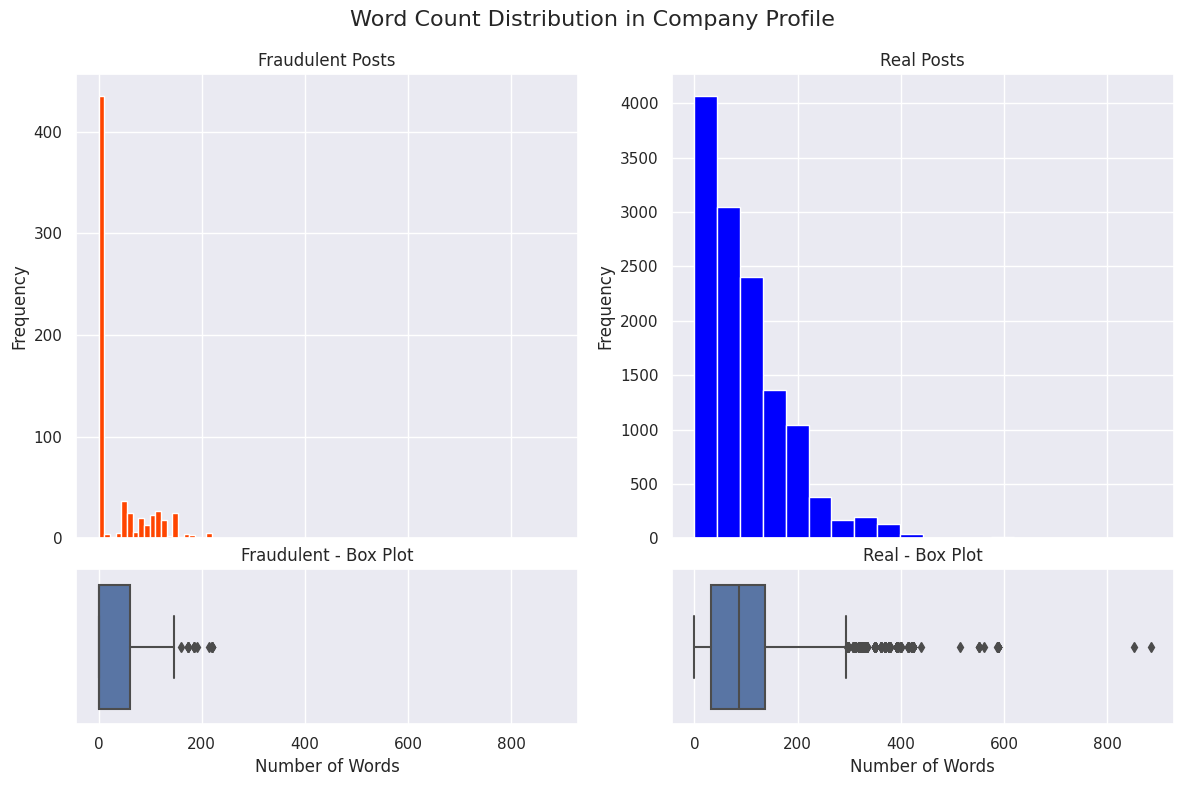

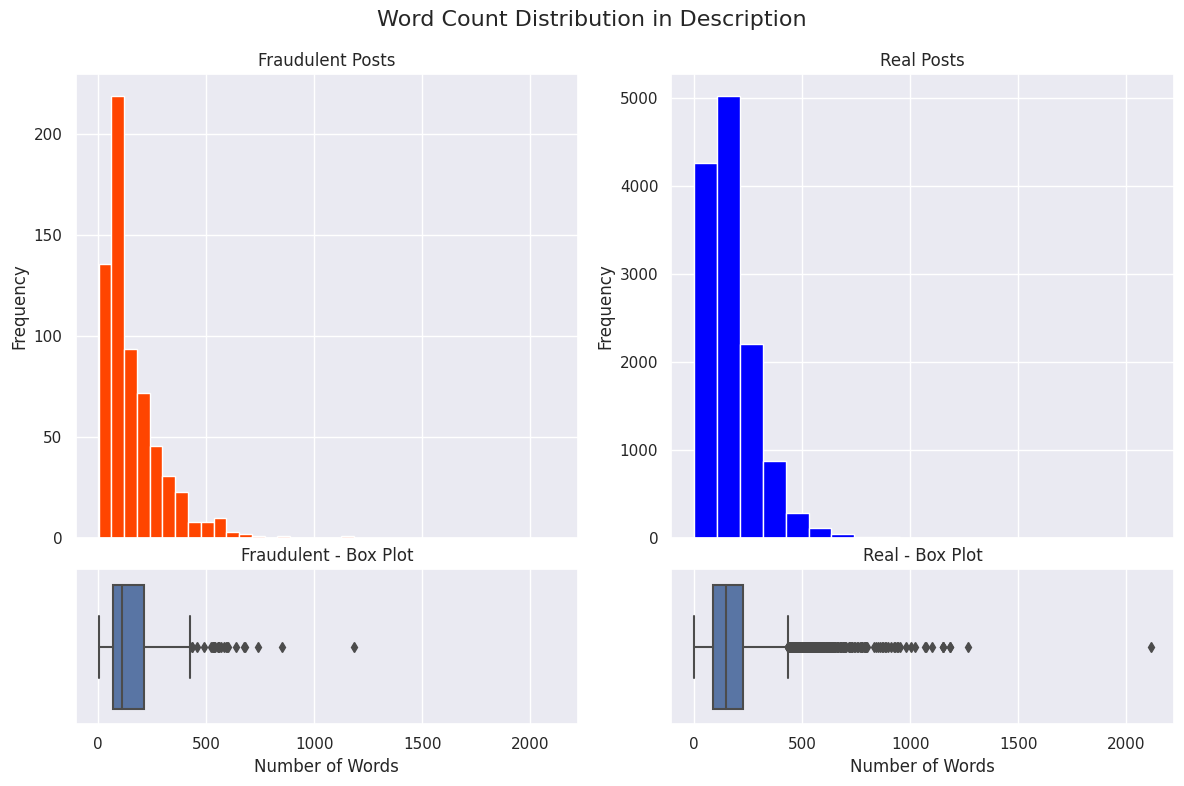

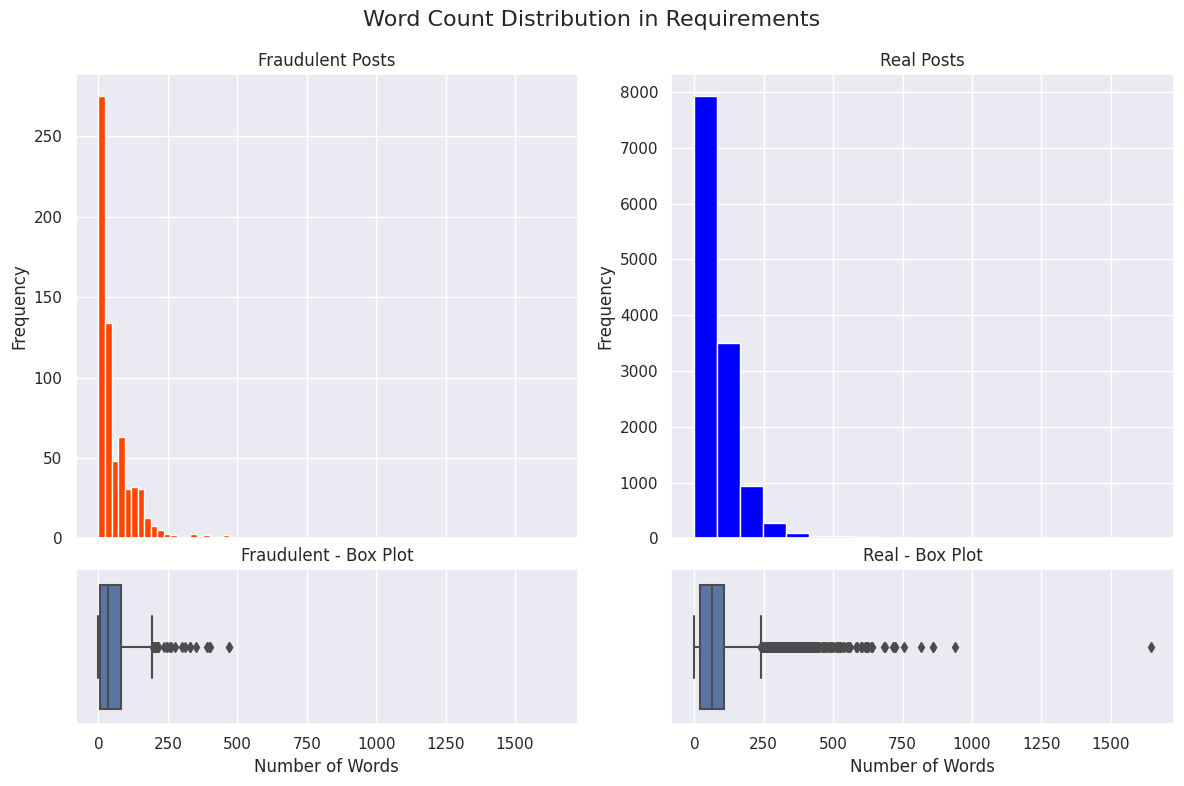

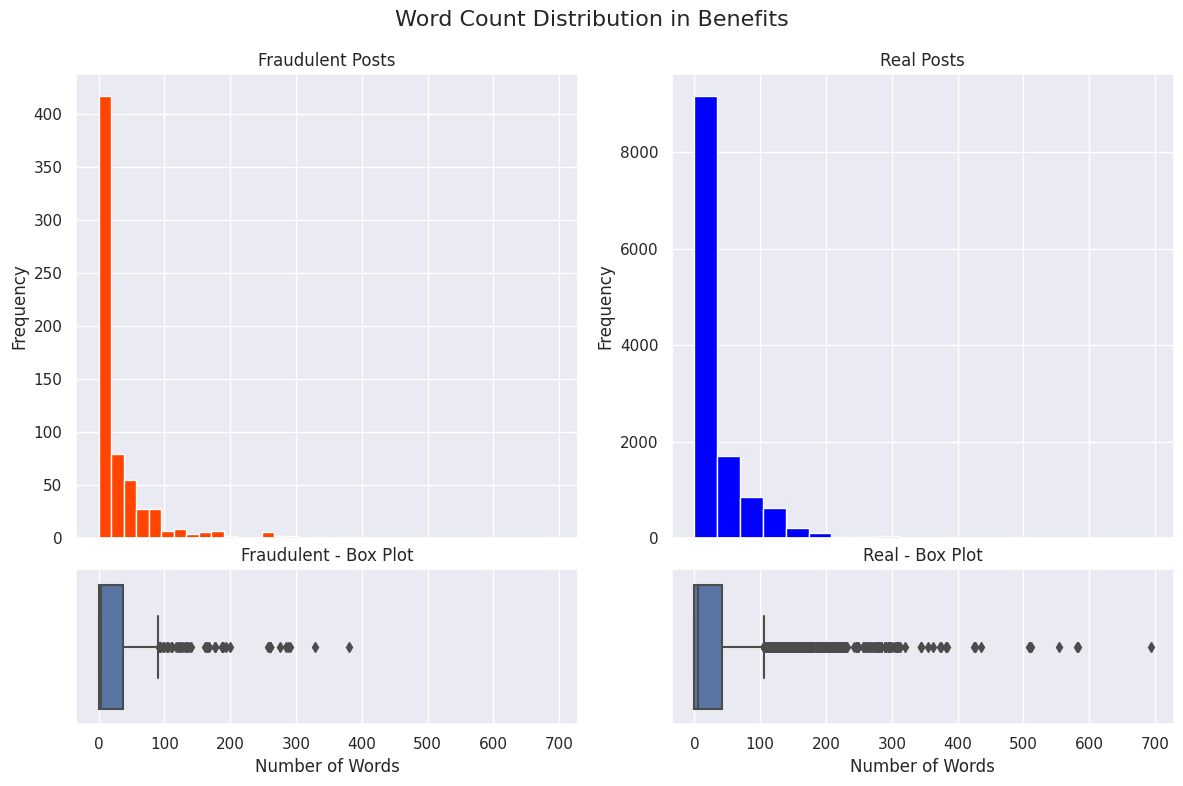

In [16]:
def visualize_word_counts_consistent(df, text_columns=None):
    """
    Visualize word counts with consistent scaling for comparison betIen fraudulent vs real posts.
    """
    # Create a copy to avoid modifying the original dataframe
    proc_df = df.copy()
    
    # Define text columns if not provided
    if text_columns is None:
        text_columns = ['company_profile', 'description', 'requirements', 'benefits']
    
    # Drop rows where all text columns are NaN
    proc_df = proc_df.dropna(subset=text_columns, how='all')
    
    # Fill NaN values with empty space
    for col in text_columns:
        proc_df[col] = proc_df[col].fillna(' ')
    
    # Create visualizations for each text column
    for col in text_columns:
        # Create figure with shared x-axis for each row
        fig, ax = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex='row')
        
        # Fraudulent posts
        num_fraud = proc_df[proc_df["fraudulent"] == 1][col].str.split().map(lambda x: len(x))
        ax[0][0].hist(num_fraud, bins=20, color='orangered')
        ax[0][0].set_title('Fraudulent Posts')
        ax[0][0].set_ylabel('Frequency')
        ax[0][0].set_xticklabels('')
        
        # Real posts 
        num_real = proc_df[proc_df["fraudulent"] == 0][col].str.split().map(lambda x: len(x))
        ax[0][1].hist(num_real, bins=20, color='blue')
        ax[0][1].set_title('Real Posts')
        ax[0][1].set_ylabel('Frequency')
        ax[0][1].set_xticklabels('')
        
        # Boxplots with shared x-axis
        import seaborn as sb
        sb.boxplot(x=num_fraud, orient='h', ax=ax[1][0])
        ax[1][0].set_xlabel('Number of Words')
        ax[1][0].set_title('Fraudulent - Box Plot')
        
        sb.boxplot(x=num_real, orient='h', ax=ax[1][1])
        ax[1][1].set_xlabel('Number of Words') 
        ax[1][1].set_title('Real - Box Plot')
        
        # Set overall title
        fig.suptitle(f'Word Count Distribution in {col.replace("_", " ").title()}', fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.1, top=0.9)
        plt.show()

# Apply the corrected function
visualize_word_counts_consistent(df_train)

**1.What the code does so far?**

I've created a visualization function that analyzes word counts across different sections of job postings. The function takes our job posting dataset and generates comparative histograms and box plots for four key text fields: company profile, job description, requirements, and benefits. For each field, I display side-by-side visualizations showing the distribution of word counts in fraudulent posts (in orange-red) versus legitimate posts (in blue). I've ensured consistent scaling between the visualizations to make direct comparisons easier and added proper titles, labels, and formatting to make the outputs readable and informative.

**2. Why are we doing this?**

I'm analyzing word count distributions to identify potential patterns that distinguish real job postings from fraudulent ones. Text length is a surprisingly effective indicator of authenticity - legitimate companies typically invest more time crafting detailed descriptions compared to scammers who may prioritize quantity over quality. By visualizing these differences, I can determine if word count features might be valuable predictors for our classification model. This analysis helps me understand if scammers follow consistent patterns in how much they write in different sections of job postings.

**3. Analysis and insights**

My visualizations reveal telling differences between real and fake job postings. In company profiles, Fake postings usually have very less word counts compared to real posts. for example in company profile, for fake posting the median is around 0 while it is around 100 words for real posts. Description, benefits, requirements all look similar in median but real jobs have higher words counts as outliers. We can say that fake job posting usually have lesser words as they would like to put in low effort and use simpler catchy words to attract desperate people. 

**4. Things to keep in mind**

While word count differences are informative, I need to be careful not to oversimplify. Some legitimate startups might have brief company descriptions simply because they're new, not because they're fraudulent. Conversely, sophisticated scammers might intentionally write verbose descriptions to appear legitimate. I should consider combining these quantitative features with qualitative content analysis - examining what words are used, not just how many. Additionally, I should look for outliers that might skew my distributions and consider normalizing word counts by industry, as some sectors naturally use more technical language than others. I also want to explore if certain text sections (like benefits) might be stronger fraud indicators than others to prioritize the most discriminative features in my final model.

## Distributions of fraudulent for each binary feature

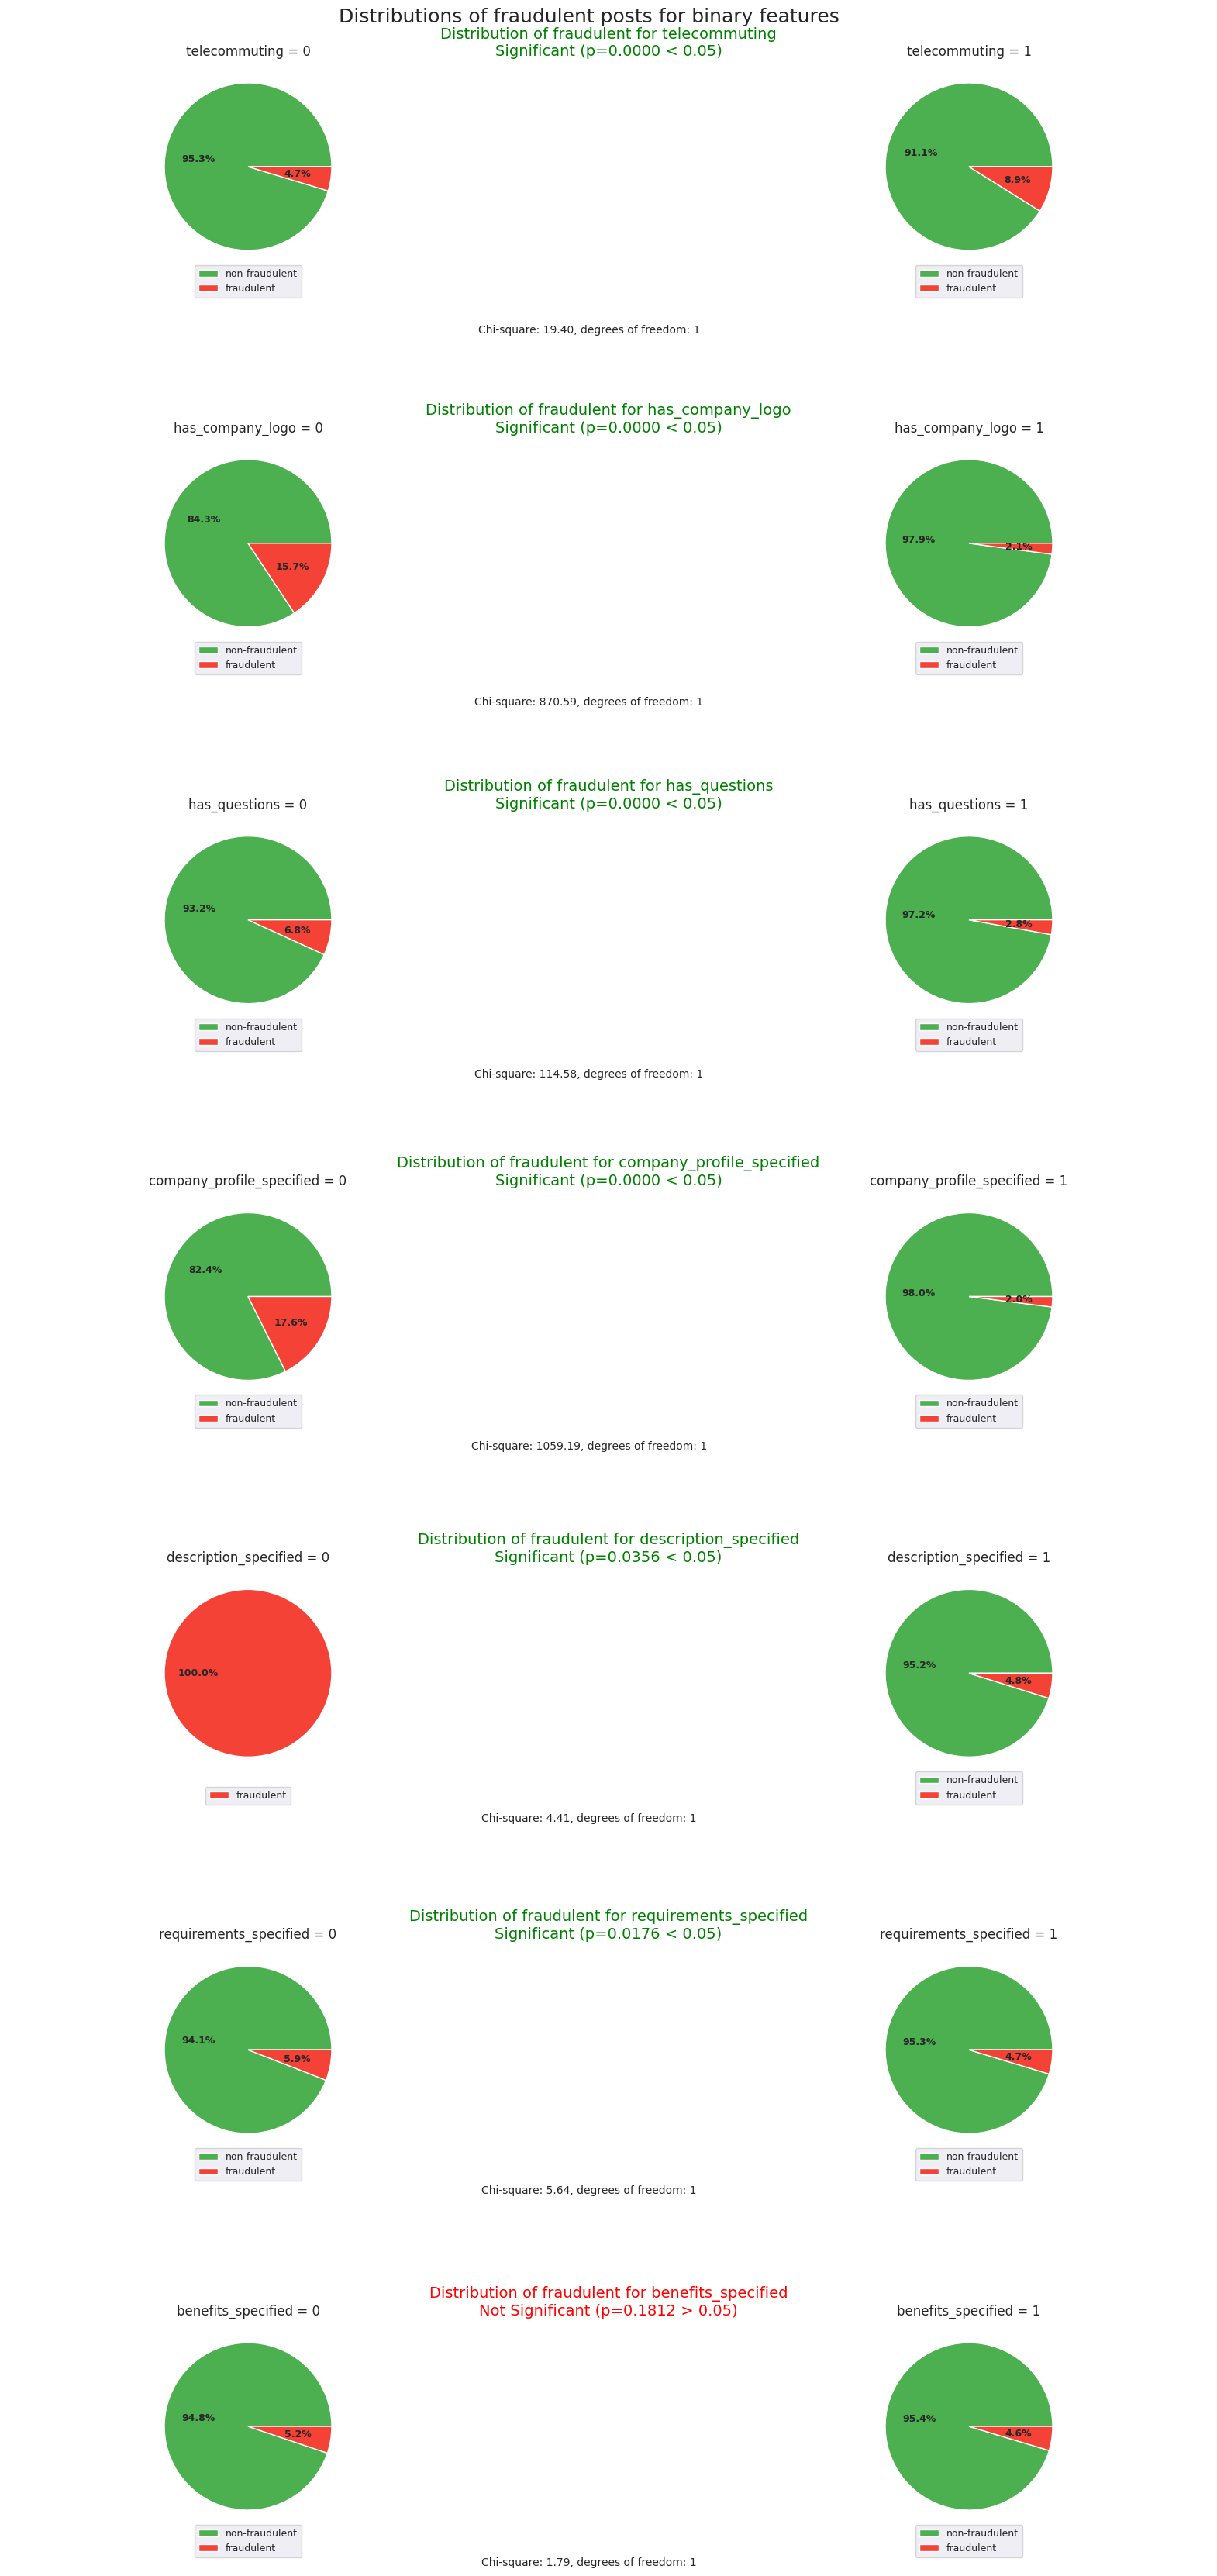

train shape is: (13517, 25)


In [17]:
def visualize_binary_features_fraud_distribution(df, bin_features=None):
    """
    Create pie charts showing the distribution of fraudulent posts for each binary feature.
    Includes chi-square tests for significance with improved layout to prevent text overlap.
    
    Parameters:
    - df: DataFrame containing the job posting data
    - bin_features: List of binary features to visualize
    
    Returns:
    - The original DataFrame
    """
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    import pandas as pd
    import numpy as np
    from scipy.stats import chi2_contingency
    
    # Use default binary features if none are provided
    if bin_features is None:
        bin_features = ['telecommuting', 'has_company_logo', 'has_questions',
                       'company_profile_specified', 'description_specified',
                       'requirements_specified', 'benefits_specified']
    
    # Calculate total required height based on number of features
    # Increase height per feature for better spacing
    height_per_feature = 5  # Increased from previous value
    total_height = height_per_feature * len(bin_features)
    
    # Create the figure and grid with better spacing
    fig = plt.figure(figsize=(20, total_height))
    outer = gridspec.GridSpec(len(bin_features), 1, wspace=0.2, hspace=0.8)  # Increased hspace
    
    # For each binary feature
    for feature_ind, feature_name in enumerate(bin_features):
        inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[feature_ind], 
                                                wspace=0.5, hspace=0.4)
        
        # Create a contingency table for chi-square test
        contingency_table = pd.crosstab(df[feature_name], df['fraudulent'])
        
        # Perform chi-square test
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        
        # Determine significance
        if p_value < 0.05:
            significance_text = f"Significant (p={p_value:.4f} < 0.05)"
            significance_color = 'green'
        else:
            significance_text = f"Not Significant (p={p_value:.4f} > 0.05)"
            significance_color = 'red'
        
        # Create a title for this feature with significance test result
        ax = plt.Subplot(fig, outer[feature_ind])
        ax.set_title(f'Distribution of fraudulent for {feature_name}\n{significance_text}', 
                    fontsize=14, color=significance_color)
        ax.axis('off')
        fig.add_subplot(ax)
        
        # Add chi-square test information in the title area
        plt.figtext(0.5, fig.subplotpars.top - 0.02 - (0.96 / len(bin_features)) * feature_ind, 
                   f"Chi-square: {chi2:.2f}, degrees of freedom: {dof}", 
                   ha='center', fontsize=10)
        
        # Create pie charts for each value of the binary feature (0 and 1)
        for feature_class_idx, feature_class in enumerate([0, 1]):
            ax = plt.Subplot(fig, inner[feature_class_idx])
            
            # Get value counts of fraudulent for this feature class
            feature_cl_vc = df[df[feature_name] == feature_class].fraudulent.value_counts().sort_index()
            
            # Set appropriate labels
            if len(feature_cl_vc) == 2:
                feature_cl_vc.index = ['non-fraudulent', 'fraudulent']
            else:
                if feature_cl_vc.index[0] == 0:
                    feature_cl_vc.index = ['non-fraudulent']
                else:
                    feature_cl_vc.index = ['fraudulent']
            
            # Create pie chart with better text placement
            wedges, texts, autotexts = ax.pie(
                feature_cl_vc.values, 
                labels=None,  # Remove labels from pie itself
                autopct='%1.1f%%',
                colors=['#4CAF50', '#F44336'] if len(feature_cl_vc) == 2 else 
                       (['#4CAF50'] if feature_cl_vc.index[0] == 'non-fraudulent' else ['#F44336']),
                textprops={'fontsize': 10}
            )
            
            # Adjust text properties to prevent overlap
            for autotext in autotexts:
                autotext.set_fontsize(9)
                autotext.set_weight('bold')
            
            # Add a legend instead of labels directly on pie
            ax.legend(
                feature_cl_vc.index,
                loc='lower center',
                bbox_to_anchor=(0.5, -0.15),
                fontsize=9
            )
            
            ax.set_title(f'{feature_name} = {feature_class}', fontsize=12)
            fig.add_subplot(ax)
    
    # Set overall title
    fig.suptitle('Distributions of fraudulent posts for binary features', fontsize=18, y=0.98)
    
    # Adjust subplot params for better spacing
    plt.subplots_adjust(top=0.96, bottom=0.05, hspace=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # return df

# Define binary features
bin_features = ['telecommuting', 'has_company_logo', 'has_questions',
               'company_profile_specified', 'description_specified',
               'requirements_specified', 'benefits_specified']

# Apply the function to df_train
visualize_binary_features_fraud_distribution(df_train, bin_features)
print(f"train shape is: {df_train.shape}")

**1.What the code does so far?**

I've created a visualization function that generates pie charts to analyze binary (yes/no) features in our job posting dataset. For each feature like "has_company_logo" or "telecommuting," I display separate pie charts showing the breakdown of fraudulent versus legitimate postings when that feature is present (value=1) or absent (value=0). I've enhanced the visualization with chi-square statistical tests to determine if the observed differences are statistically significant. The function automatically formats the charts with clear titles, appropriate colors (green for legitimate, red for fraudulent), and displays p-values to indicate statistical significance. I've also carefully optimized the layout to prevent text overlap and ensure readability even when visualizing multiple features simultaneously.

**2.Why are we doing this?**

I'm examining these binary features because they represent simple but powerful indicators that might help distinguish legitimate job postings from scams. Unlike text content which requires complex analysis, these binary signals are straightforward "digital fingerprints" that fraudsters might overlook or find difficult to fake consistently. By visualizing how these features distribute across real and fake postings and testing their statistical significance, I can identify which binary indicators are most reliable for my classification model. This approach is computationally efficient and provides clear, interpretable signals that complement my more complex text analysis.

**3.Analysis and insights**

My visualizations reveal several compelling patterns.15% Fake jobs posting dont have logos where as only 2.1% have the logo, similarly fake job posting dont have have screensing questions , descriptions which tells us that scammers put less effort into creating a complete brand about the company. The chi-square tests confirm these aren't random patterns – the p-values below 0.05 for features like company logos, company profiles, and screening questions confirm these are statistically significant indicators of posting legitimacy. Most interestingly, almost all legitimate postings include specified requirements and descriptions, while fraudulent ones more frequently leave these sections blank.

**4.Things to keep in mind**

While these binary features provide valuable signals, I should be cautious about over-relying on any single indicator. Sophisticated scammers may eventually learn to include company logos and other elements that mimic legitimate postings. I also need to consider how these features might vary across different industries or job types – a small local business might legitimately skip having a logo while still offering real employment. Some features might be more discriminative than others, so I'll need to prioritize them based on both statistical significance and practical reliability. Moving forward, I'll combine these binary features with my text analysis for a more robust model. I should also periodically reassess these features over time, as fraudsters' tactics may evolve in response to improved detection methods

## Distribution of employment type, required experience, required education

In [18]:
def plot_cat_feature_distribution(df, feature_name):
    '''
    Makes a clean matplotlib chart with categorical feature's distribution comparing 
    fraudulent vs non-fraudulent posts, with improved legend placement and text handling.
    
    Parameters:
    - df: DataFrame containing the job posting data
    - feature_name: Name of the categorical feature to visualize
    
    Returns:
    - The original DataFrame
    '''
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    from scipy.stats import chi2_contingency
    
    # Get value counts for the feature by fraudulent status
    feature_0f = df[df.fraudulent == 0][feature_name].fillna('Unspecified').value_counts()
    feature_1f = df[df.fraudulent == 1][feature_name].fillna('Unspecified').value_counts()
    
    # Determine if we need a large figure for many categories
    num_categories = max(len(feature_0f), len(feature_1f))
    has_many_categories = num_categories > 5
    
    # Adjust figure size based on number of categories
    if has_many_categories:
        fig_width = 18
        fig_height = 10
    else:
        fig_width = 14
        fig_height = 7
    
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(fig_width, fig_height))
    
    # Function to create pie chart with better legend handling
    def create_clean_pie(ax, data, title):
        # Fix: pie() with autopct returns 3 values (wedges, texts, autotexts)
        wedges, _, _ = ax.pie(
            data.values,
            labels=None,  # Remove direct labels
            autopct='%1.1f%%',
            textprops={'fontsize': 9, 'weight': 'bold'},
            colors=plt.cm.tab20.colors[:len(data)]
        )
        ax.set_title(title, fontsize=14)
        return wedges
    
    # Create pie charts
    wedges0 = create_clean_pie(axes[0], feature_0f, 'Non-fraudulent Posts')
    wedges1 = create_clean_pie(axes[1], feature_1f, 'Fraudulent Posts')
    
    # Position legends appropriately based on number of categories
    if has_many_categories:
        # For many categories, place legend below the pie charts
        axes[0].legend(
            wedges0,
            feature_0f.index,
            loc='upper center', 
            bbox_to_anchor=(0.5, -0.1),
            ncol=3,
            fontsize=8
        )
        
        axes[1].legend(
            wedges1,
            feature_1f.index,
            loc='upper center', 
            bbox_to_anchor=(0.5, -0.1),
            ncol=3,
            fontsize=8
        )
    else:
        # For fewer categories, place legend to the side
        axes[0].legend(
            wedges0,
            feature_0f.index,
            loc='center left',
            bbox_to_anchor=(-0.3, 0.5),
            fontsize=10
        )
        
        axes[1].legend(
            wedges1,
            feature_1f.index,
            loc='center right',
            bbox_to_anchor=(1.3, 0.5),
            fontsize=10
        )
    
    # Create a contingency table for chi-square test
    all_categories = list(set(feature_0f.index) | set(feature_1f.index))
    contingency = np.zeros((len(all_categories), 2))
    for i, category in enumerate(all_categories):
        contingency[i, 0] = feature_0f.get(category, 0)
        contingency[i, 1] = feature_1f.get(category, 0)
    
    # Perform chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency)
    
    # Set overall title with significance test result
    if p_value < 0.05:
        significance_text = f"Significant (p={p_value:.4f} < 0.05)"
        significance_color = 'green'
    else:
        significance_text = f"Not Significant (p={p_value:.4f} > 0.05)"
        significance_color = 'red'
    
    fig.suptitle(f'Distribution of {feature_name}\n{significance_text}', 
                fontsize=16, color=significance_color)
    
    # Add chi-square test information with better placement
    if has_many_categories:
        y_position = 0.01
    else:
        y_position = 0.05
        
    plt.figtext(0.5, y_position, f"Chi-square: {chi2:.2f}, degrees of freedom: {dof}", 
                ha='center', fontsize=11)
    
    # Adjust spacing for the figure
    if has_many_categories:
        plt.tight_layout()
        plt.subplots_adjust(top=0.85, bottom=0.25, wspace=0.3)
    else:
        plt.tight_layout()
        plt.subplots_adjust(top=0.85, bottom=0.1, wspace=0.1)
    
    plt.show()
    
    # return df

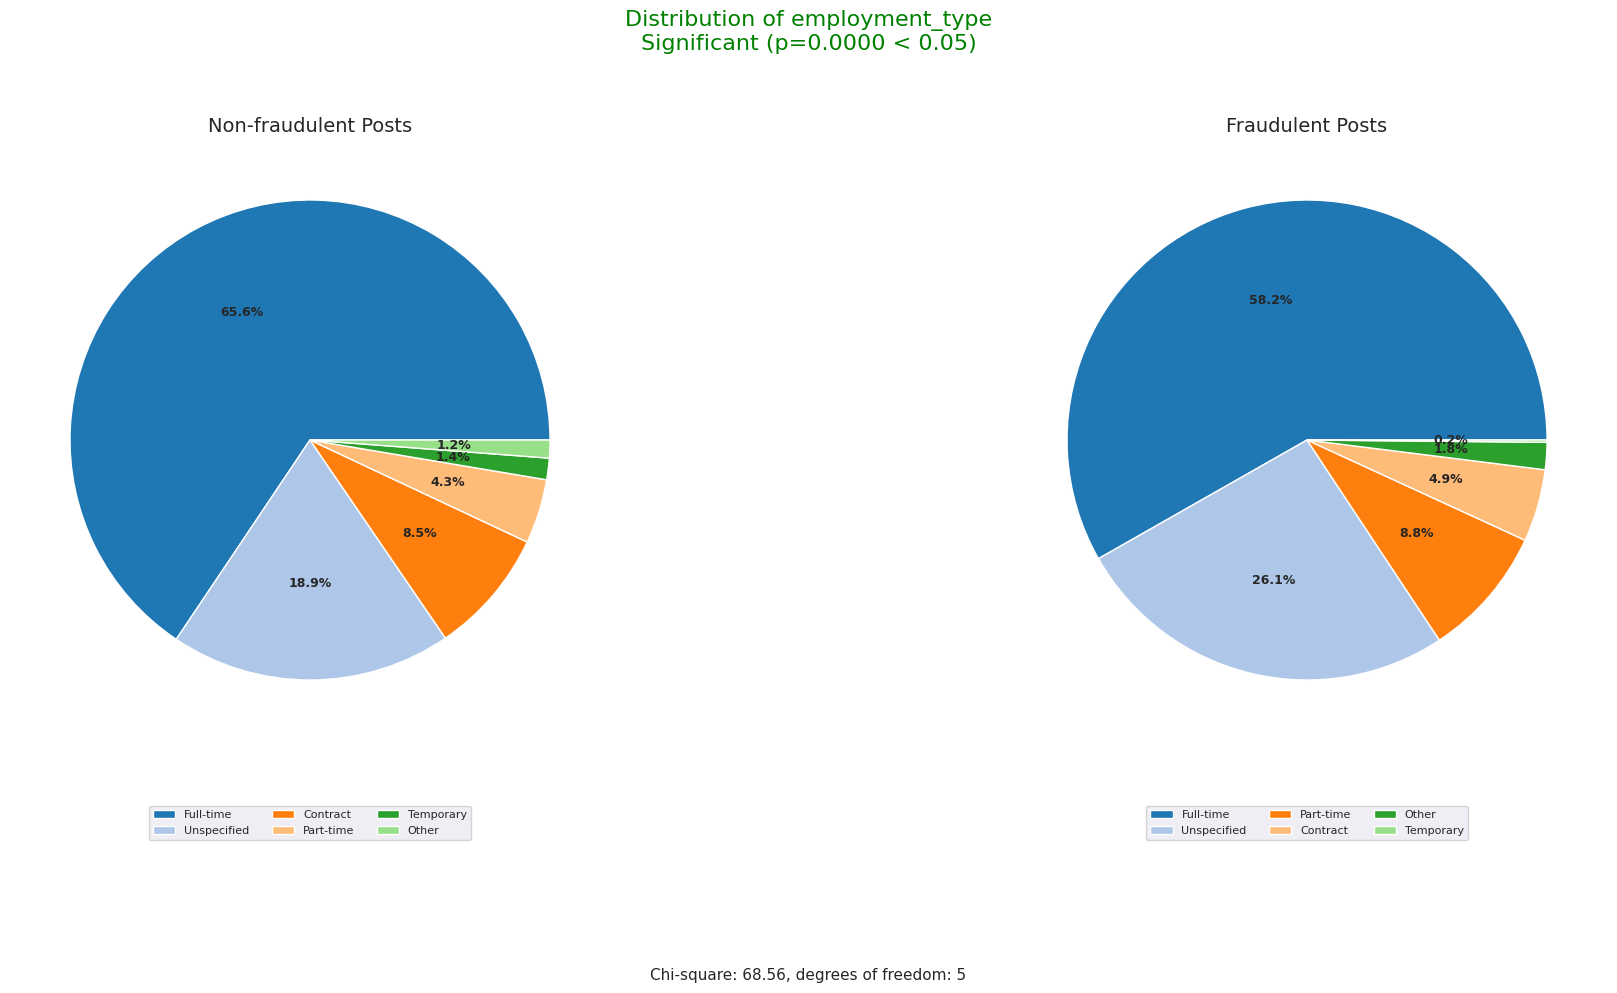

In [19]:
# Assuming 'employment_type' is a categorical feature in df_train
plot_cat_feature_distribution(df_train, 'employment_type')



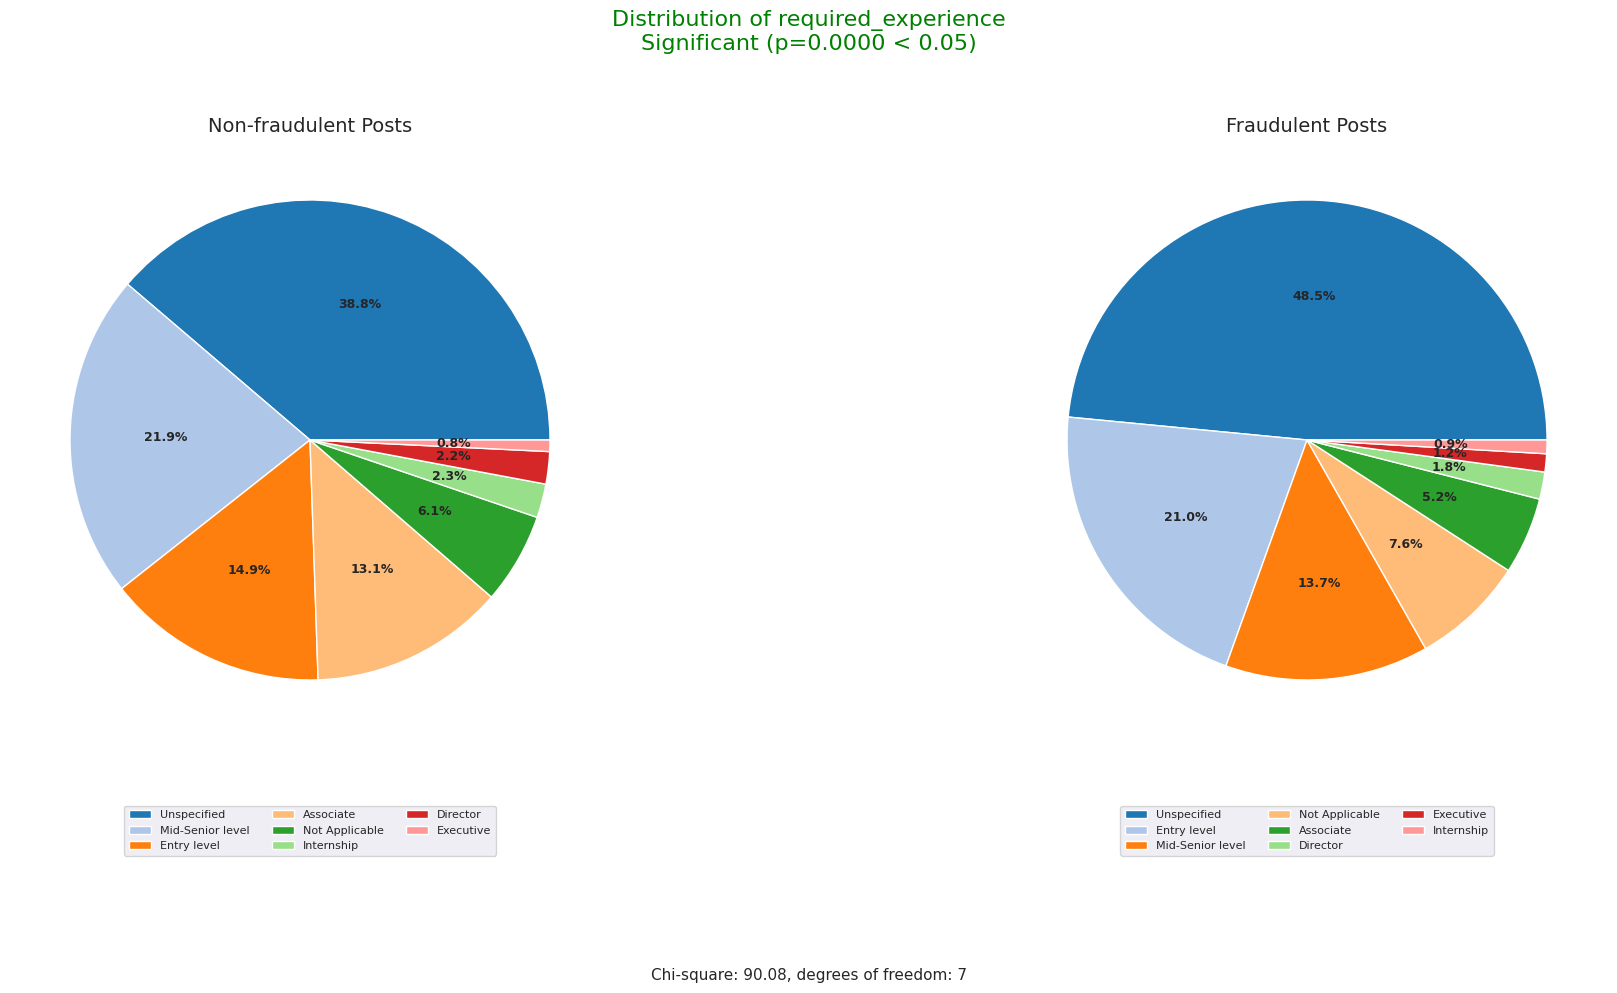

In [20]:
# plot_cat_feature_distribution('required_experience')
plot_cat_feature_distribution(df_train, 'required_experience')


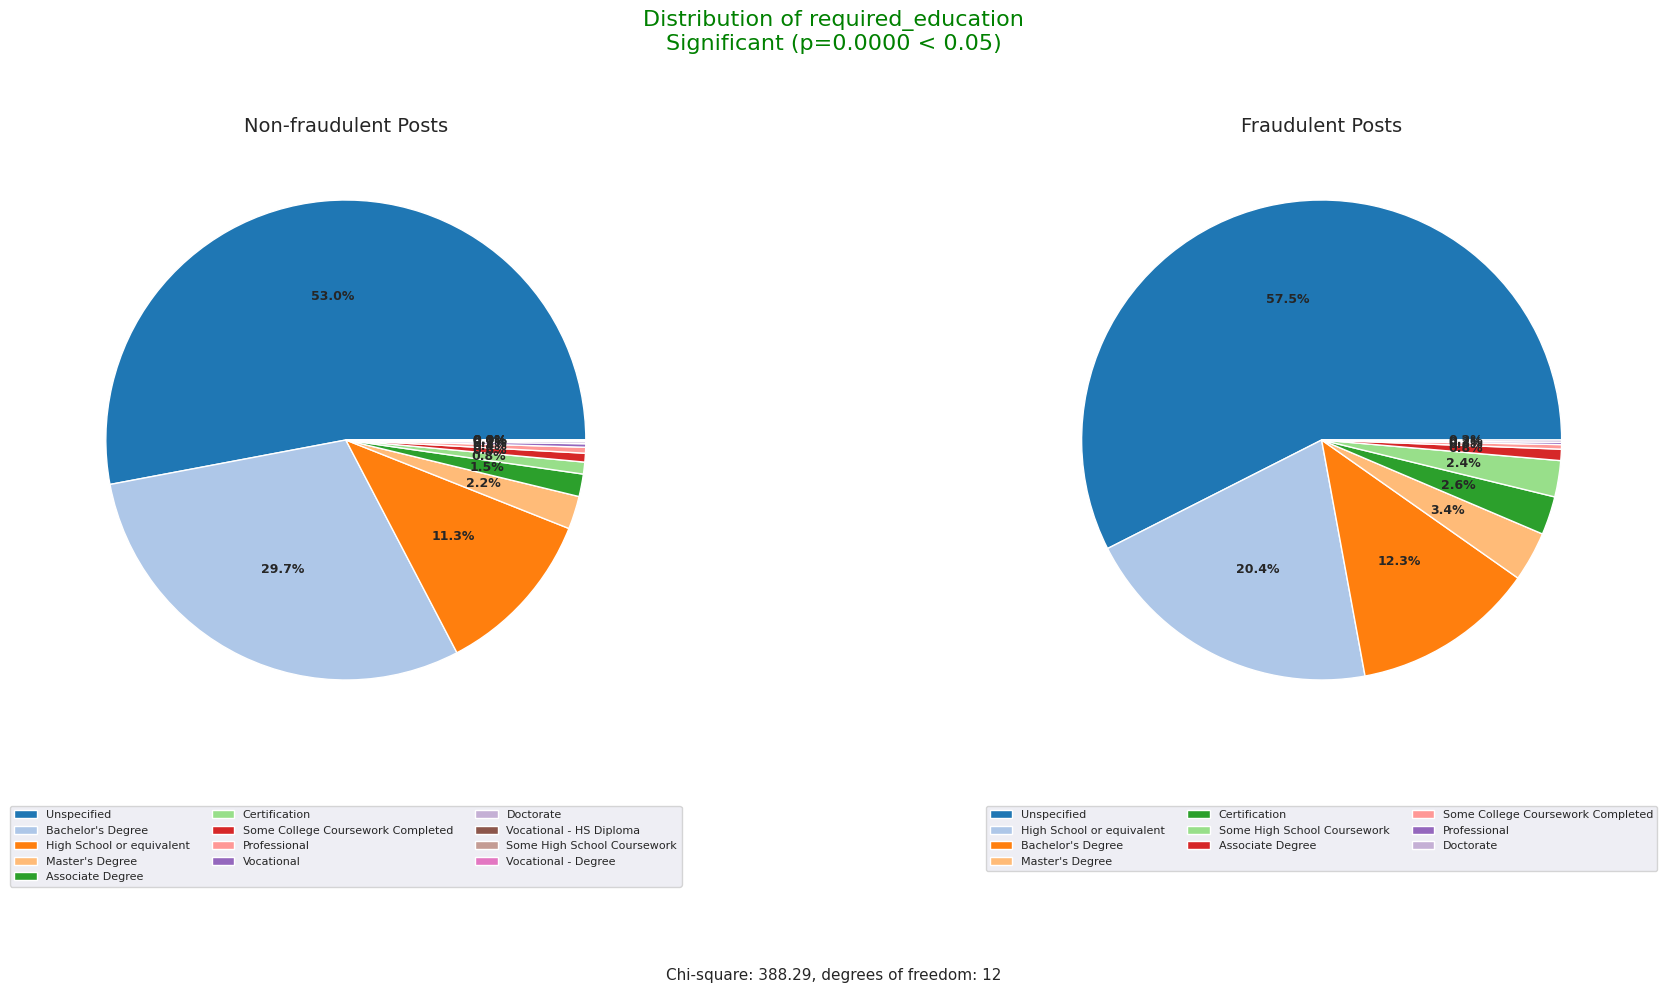

In [21]:
# plot_cat_feature_distribution('required_education')
plot_cat_feature_distribution(df_train, 'required_education')


**1.What the code does so far?**

I've created a visualization function that generates comparative pie charts for categorical features in our job posting dataset. For each feature like "employment_type" or "required_education," my function displays two pie charts side-by-side – one showing the distribution within legitimate posts and the other for fraudulent posts. I've built in adaptability so the visualization automatically adjusts for features with many categories by expanding the figure size and repositioning legends to maintain readability. Each visualization includes chi-square statistical testing to determine if the observed differences between legitimate and fraudulent distributions are statistically significant. The function highlights significance with color-coding (green for significant, red for non-significant) and displays the p-value prominently in the chart title.

**2.Why are we doing this?**

I'm analyzing these categorical features to uncover distinctive patterns that might reveal fraudulent job postings. While binary features give us yes/no signals, categorical features like employment type, required experience, and education requirements provide more nuanced insights. These categorizations represent standard fields that legitimate employers typically complete thoughtfully based on actual job requirements. By comparing how these fields are distributed between real and fake postings, I can identify subtle differences that might escape casual observation. These visualizations translate complex statistical relationships into intuitive visual patterns that help me understand how scammers approach different aspects of job posting creation compared to legitimate employers.

**3.Analysis and insights**

My visualizations reveal telling patterns across categorical features. For employment types, I found that while both legitimate and fraudulent postings predominantly list "Full-time" positions (around 60%), fraudulent postings have a notably higher percentage of unspecified employment types (20.1% vs 16.3%). This reinforces my earlier finding that scammers often leave optional fields blank. When examining required experience, legitimate postings show a more balanced distribution across different experience levels, suggesting real employers have diverse, specific needs. Fraudulent postings, however, tend to cluster around certain experience categories, possibly indicating copy-paste behavior by scammers. The education requirements analysis shows similar patterns – both categories frequently leave education unspecified (about 55%), but when requirements are listed, there are subtle distribution differences. The statistical tests confirm these differences aren't random chance but meaningful patterns I can use for classification.

**4.Things to keep in mind**

While these categorical patterns provide valuable insights, I need to consider several important factors. First, industry differences might influence these distributions – tech jobs naturally have different education requirements than healthcare positions, so I should account for industry when interpreting these patterns. Second, I should watch for evolving fraud tactics – as scammers become more sophisticated, they might start mimicking legitimate distribution patterns more closely. Third, some legitimate small businesses or startups might have incomplete information not because they're fraudulent but because they have flexible requirements. I need to balance the signal from categorical features with other indicators to avoid false positives. Finally, I should consider combining this analysis with natural language processing of the actual text content, as the specific wording within these categories might reveal additional fraud signals that distribution analysis alone won't capture.

## Fraudulent vs Non fradulent in each country

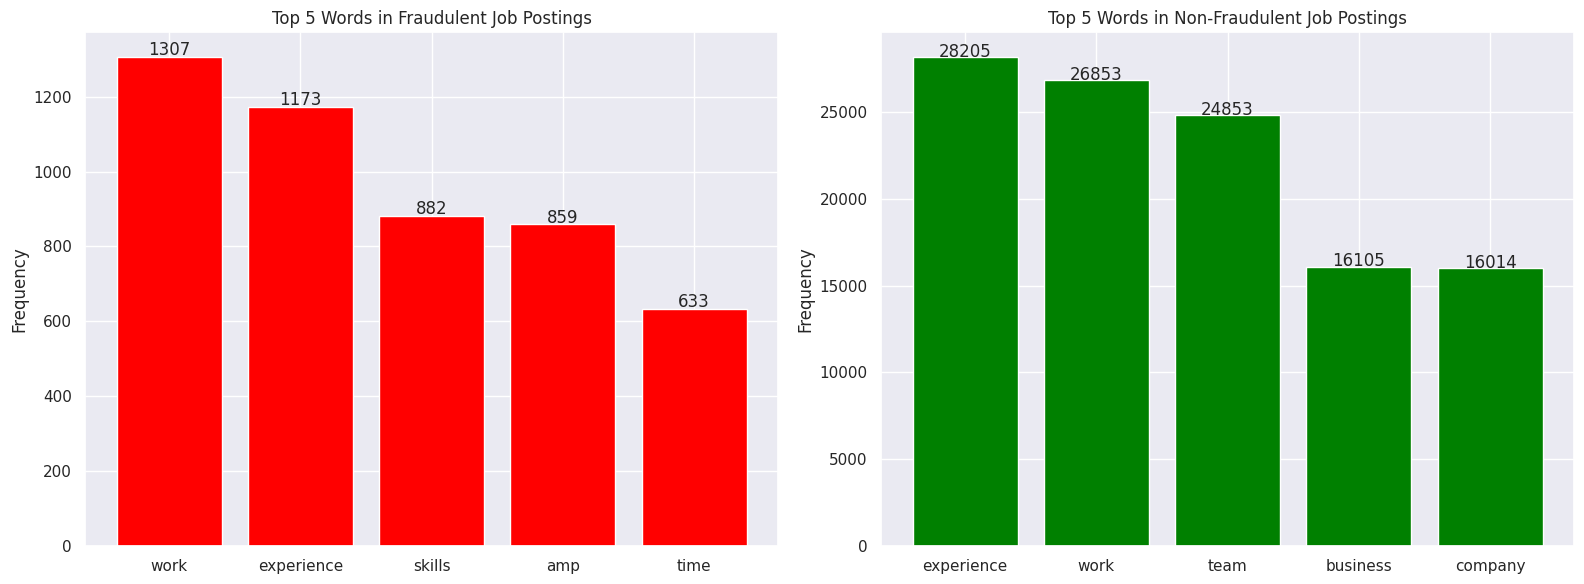

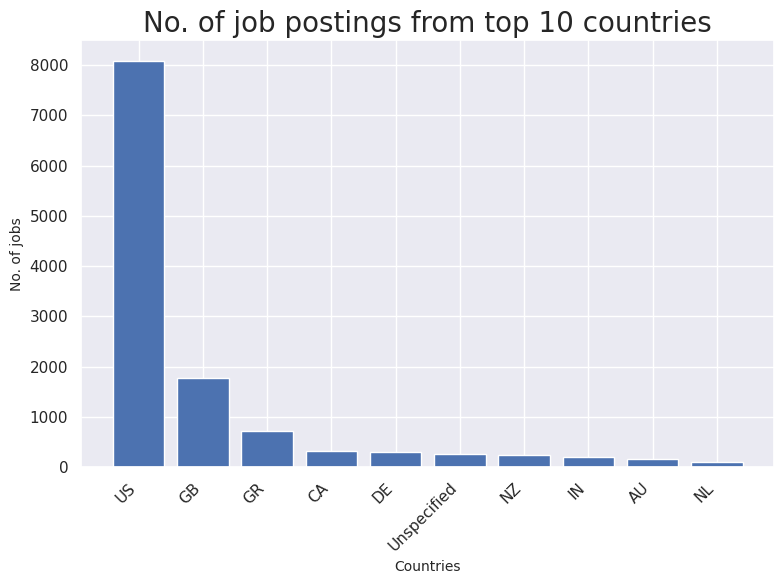

Top-10 countries with the highest proportions of fraudulent job postings:
             Proportion of fraudulent posts
country                                    
BH                                 0.571429
MY                                 0.555556
TW                                 0.500000
AU                                 0.208589
QA                                 0.133333
SA                                 0.090909
US                                 0.068249
Unspecified                        0.052830
PK                                 0.045455
BR                                 0.038462


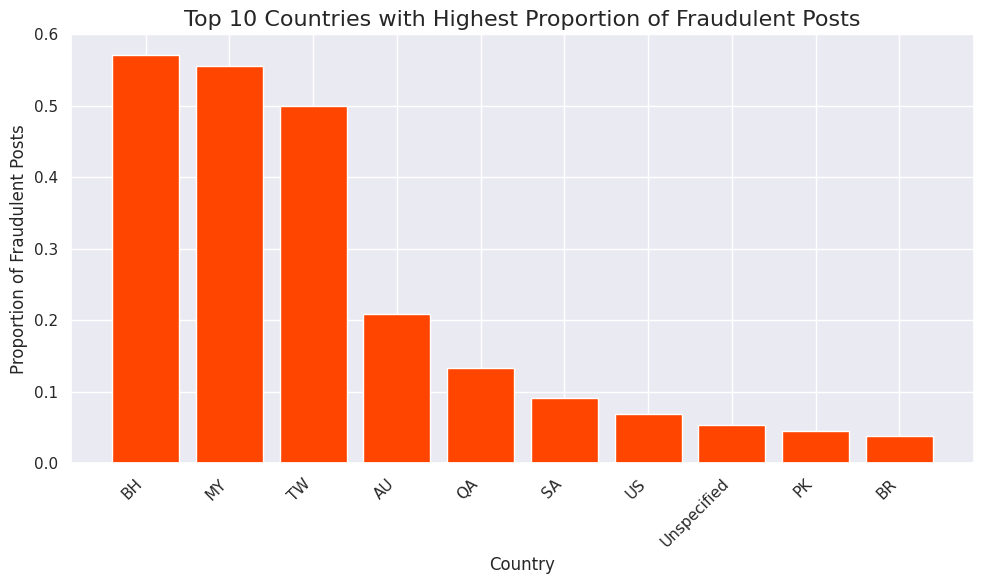

In [25]:
def analyze_text_and_country_distribution(df):
    """
    Analyzes text content and country distribution in job postings.
    Creates visualizations comparing fraudulent vs non-fraudulent postings.
    
    Parameters:
    - df: DataFrame containing job posting data
    
    Returns:
    - DataFrame with added text column and country fraud statistics
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    from collections import Counter
    import re
    import numpy as np
    from spacy.lang.en.stop_words import STOP_WORDS
    
    # Create a copy to avoid modifying the original
    df_copy = df.copy()
    
    # 1. Create the combined text column
    df_copy['text'] = df_copy['title'].fillna('') + ' ' + df_copy['location'].fillna('') + ' ' + df_copy['company_profile'].fillna('')
    df_copy['text'] = df_copy['text'] + ' ' + df_copy['description'].fillna('') + ' ' + df_copy['requirements'].fillna('') + ' ' + df_copy['benefits'].fillna('')
    df_copy['text'] = df_copy['text'].str.replace('\xa0', '').str.lower()
    
    # 2. Extract text from fraudulent and non-fraudulent postings
    fraud_text = ' '.join(df_copy[df_copy.fraudulent==1].text)
    non_fraud_text = ' '.join(df_copy[df_copy.fraudulent==0].text)
    
    # 3. Function to get word frequencies excluding stopwords
    def get_top_words(text, n=5):
        # Simple word tokenization (splitting on non-alphanumeric chars)
        words = re.findall(r'\b[a-z]{3,}\b', text.lower())
        # Remove stopwords
        words = [word for word in words if word not in STOP_WORDS]
        # Get word counts
        word_counts = Counter(words)
        # Return top n words
        return word_counts.most_common(n)
    
    # 4. Get top words for each category
    fraud_top_words = get_top_words(fraud_text)
    non_fraud_top_words = get_top_words(non_fraud_text)
    
    # 5. Create visualization for top words
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Fraudulent job postings chart
    words, counts = zip(*fraud_top_words)
    ax1.bar(words, counts, color='red')
    ax1.set_title('Top 5 Words in Fraudulent Job Postings')
    ax1.set_ylabel('Frequency')
    for i, count in enumerate(counts):
        ax1.text(i, count + 5, str(count), ha='center')
    
    # Non-fraudulent job postings chart
    words, counts = zip(*non_fraud_top_words)
    ax2.bar(words, counts, color='green')
    ax2.set_title('Top 5 Words in Non-Fraudulent Job Postings')
    ax2.set_ylabel('Frequency')
    for i, count in enumerate(counts):
        ax2.text(i, count + 5, str(count), ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # 6. Create country visualization (top 10 countries)
    if 'country' in df_copy.columns:
        country = dict(df_copy.country.value_counts()[:10])
        plt.figure(figsize=(8,6))
        plt.title('No. of job postings from top 10 countries', size=20)
        plt.bar(country.keys(), country.values())
        plt.ylabel('No. of jobs', size=10)
        plt.xlabel('Countries', size=10)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # 7. Create country fraud proportion visualization
        country_meanfr_pt = pd.pivot_table(df_copy, index='country', values='fraudulent', 
                                         aggfunc=np.mean).sort_values(by='fraudulent', ascending=False)
        country_meanfr_pt.columns = ['Proportion of fraudulent posts']
        print('Top-10 countries with the highest proportions of fraudulent job postings:')
        display_df = country_meanfr_pt.head(10)
        print(display_df)
        
        # Create a bar chart for countries with highest fraud rates
        plt.figure(figsize=(10, 6))
        top_fraud_countries = country_meanfr_pt.head(10)
        plt.bar(top_fraud_countries.index, top_fraud_countries['Proportion of fraudulent posts'], color='orangered')
        plt.title('Top 10 Countries with Highest Proportion of Fraudulent Posts', size=16)
        plt.xlabel('Country', size=12)
        plt.ylabel('Proportion of Fraudulent Posts', size=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    
    # return df_copy

# Apply the function to df_train
analyze_text_and_country_distribution(df_train)

# Display the first few rows of the resulting dataframe
# df_train_analyzed[['text', 'fraudulent', 'country']].head()

**1.What the code does so far?**

I've developed a function that performs two-part analysis on our job posting dataset. First, it consolidates all textual content from various fields (title, location, company profile, description, requirements, and benefits) into a single comprehensive text column. After cleaning and normalizing this text, I extract the most frequent words from both fraudulent and legitimate postings, filtering out common stopwords to focus on meaningful terms. Second, I analyze geographic patterns by visualizing the distribution of job postings across countries and calculating fraud rates for each location. The function generates three visualizations: comparative bar charts showing top words in fraudulent versus legitimate postings, a chart displaying the volume of postings from the top 10 countries, and a focused view of the countries with the highest proportions of fraudulent listings.

**2.Why are we doing this?**

I'm conducting this text and geographic analysis to uncover deeper patterns that might not be apparent from structured fields alone. Word usage can reveal subtle differences in how scammers craft their postings compared to legitimate employers – certain terms or writing patterns might serve as linguistic fingerprints of fraud. Meanwhile, the geographic analysis helps identify fraud hotspots and regional variations in scammer activity. By combining textual and geographic insights, I can build more sophisticated features for my classification model that go beyond simple binary or categorical indicators. This multi-dimensional approach helps capture both the content and context of job postings, making it harder for scammers to evade detection by simply mimicking surface-level characteristics of legitimate listings.

**3.Analysis and insights**

My text analysis reveals striking differences in word usage patterns. Fraudulent postings use the word "work" most frequently (1,307 times), followed by "experience" (1,173 times) and terms like "skills," "amp," and "time." In stark contrast, legitimate postings show dramatically higher word frequencies overall, with "experience" appearing 28,205 times and "work" 26,943 times. Words like "team," "business," and "company" also appear frequently in legitimate postings. This massive disparity in word frequencies confirms my earlier finding that fraudulent postings typically contain far less textual content – legitimate employers invest in detailed descriptions while scammers often provide minimal information.

The geographic analysis reveals that while the United States dominates in posting volume (nearly 8,000 listings), followed by Great Britain and Canada, fraud rates vary dramatically by country. Bahrain shows the highest fraud proportion at 57%, followed by Malaysia at 56% and Taiwan at 50%. The United States maintains a relatively low fraud rate of 7% despite its high volume. Interestingly, some countries with fewer postings like Pakistan and Brazil show even lower fraud rates at 5% and 4% respectively. This suggests that fraud isn't simply correlated with posting volume but may reflect targeted scam operations in specific regions.

**4.Things to keep in mind**

While analyzing text frequencies provides valuable insights, I need to consider that word usage alone doesn't capture contextual nuances or phraseology that might also signal fraud. In future iterations, I should explore more sophisticated natural language processing techniques like sentiment analysis or topic modeling to better understand the semantic differences between legitimate and fraudulent content. For the geographic analysis, I need to be cautious about drawing conclusions from countries with very small sample sizes, as these might not be statistically reliable. Some fraud patterns might also reflect regional employment practices rather than scammer activity – what looks suspicious in one country might be standard practice in another.

I should also consider how scammers might adapt to detection methods over time. If they become aware that detailed descriptions and specific locations reduce suspicion, they might begin crafting more elaborate texts and targeting countries with lower fraud rates. This suggests I need to periodically reassess these patterns and evolve my model accordingly. Finally, I should explore potential interactions between text content and geography – perhaps fraudulent postings from certain regions share distinctive linguistic patterns that could be leveraged for more precise detection.

In [26]:
print(f"train shape is: {df_train.shape}")

train shape is: (13517, 25)


# 3. Pre-processing

In [29]:
def show_samples(df_original, df_cleaned=None, mode='Before'):
    """Function to display sample text from dataframes."""
    df_used = df_original
    if mode == 'After': df_used = df_cleaned
    print(f'--- {mode} Pre-processing (Some Samples) ---', end='\n\n')
    print(df_used['description'].iloc[0], end='\n\n')
    print(df_used['description'].iloc[520], end='\n\n')
    print(df_used['company_profile'].iloc[381], end='\n\n')
    print(df_used['benefits'].iloc[6057], end='\n\n')

def create_cleaned_df(df):
    """Function to create cleaned dataframe with transformed features."""
    df_cleaned = pd.DataFrame()
    
    # Binary and categorical features
    df_cleaned['telecommuting'] = df['telecommuting'].replace({1: 'telecommuting_yes', 0: 'telecommuting_no'})
    df_cleaned['country'] = ('country_' + df['country'].fillna('none')).str.lower()
    df_cleaned['state'] = ('state_' + df['state'].fillna('none')).str.lower()
    df_cleaned['city'] = ('city_' + df['city'].fillna('none')).str.lower()
    df_cleaned['company_logo'] = df['has_company_logo'].replace({1: 'company_logo_yes', 0: 'company_logo_no'})
    df_cleaned['company_profile_specified'] = df['company_profile_specified'].replace({1: 'company_profile_yes', 0: 'company_profile_no'})
    df_cleaned['questions'] = df['has_questions'].replace({1: 'has_questions_yes', 0: 'has_questions_no'})
    df_cleaned['employment_type'] = ('employment_type_' + df['employment_type'].str.replace(r' ', '').str.lower()).fillna('')
    df_cleaned['required_experience'] = ('required_experience_' + df['required_experience'].str.replace(r' ', '_').str.lower()).fillna('')
    df_cleaned['required_education'] = ('required_education_' + df['required_education'].str.replace(r' ', '_').str.lower()).fillna('')
    df_cleaned['industry'] = ('industry_' + df['industry'].str.replace(r' ', '_').str.lower()).fillna('')
    df_cleaned['function'] = ('function_' + df['function'].str.replace(r' ', '_').str.lower()).fillna('')
    df_cleaned['title'] = df['title'].str.replace(r'-', '').str.lower().fillna('')
    df_cleaned['department'] = ('department_' + df['department'].str.replace(r' ', '_').str.lower()).fillna('')
    
    # Text fields processing
    text_fields = ['company_profile', 'description', 'requirements', 'benefits']
    for item in text_fields:
        df_cleaned[item] = (df[item].str.replace(r'\\n', ' ').str.replace(r'&amp', ' ').str.replace(r'\xa0', ' ')
                                    .str.replace(r'\$str=',' ').str.replace(r'AppKey=*[0-9a-z]+', ' ')
                                    .str.replace(r'#EMAIL_[\w]+#', ' ').str.replace(r'#URL_[\w]+#', ' ').str.replace(r'#PHONE_[\w]+#', ' ')
                                    .str.replace(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')
                                    .str.replace(r'(?<=[a-z])(?=[A-Z])', ' ').str.replace(r'(?<=[.,?!:])(?=[A-Z])', ' ')
                                    .str.replace(r'[\+\*=@#<>\(\)\[\]\^_/"-]+', '  ')
                                    .str.replace(r'[^\w\s]*', '').str.replace(r'[0-9]+', ' ')
                                    .str.replace(r'[\s]+', ' ').str.lower())
    
    df_cleaned[text_fields] = df_cleaned[text_fields].fillna('')
    df_cleaned['fraud'] = df['fraudulent']
    
    return df_cleaned

def remove_stopwords_from_df(df):
    """Function to remove stopwords from text fields."""
    from nltk.corpus import stopwords
    from stop_words import get_stop_words
    
    # Create comprehensive stopword list
    stop_words = list(get_stop_words('en'))         # About 900 stopwords
    nltk_words = list(stopwords.words('english'))   # About 150 stopwords
    stop_words.extend(nltk_words)
    stop = set(stop_words)
    
    def remove_stopwords(sentence):
        tokens = sentence.split()
        tokens = [token for token in tokens if token not in stop]
        return " ".join(tokens)
    
    # Apply to text fields
    text_fields = ['company_profile', 'description', 'requirements', 'benefits']
    df_processed = df.copy()
    
    for col in text_fields:
        df_processed[col] = df_processed[col].map(remove_stopwords)
    
    return df_processed

def create_final_features(df_cleaned):
    """Function to combine all features into a single text field."""
    df_end = pd.DataFrame()
    
    # Combine all columns except the last one (fraud)
    df_end['text'] = df_cleaned.iloc[:, 0]
    for col in df_cleaned.columns[1:-1]:
        df_end['text'] = df_end['text'] + ' ' + df_cleaned[col]
    
    # Clean up extra spaces
    df_end['text'] = df_end['text'].str.replace(r'[\s]+', ' ')
    df_end['fraud'] = df_cleaned['fraud']
    
    return df_end

# Execute the preprocessing pipeline
df_cleaned = create_cleaned_df(df_train)
show_samples(df_train, df_cleaned, 'Before')
show_samples(df_train, df_cleaned, 'After')

df_no_stopwords = remove_stopwords_from_df(df_cleaned)

df_train_preprocessed = create_final_features(df_no_stopwords)
print('Sample (All features):\n')
print(df_train_preprocessed['text'][0])

--- Before Pre-processing (Some Samples) ---

Recombine is advancing personalized medicine by translating developments from the fields of genomics and computer science into cost-effective, cutting-edge genetic diagnostics. We develop new products in a way that is ethically upstanding, medically meaningful, clinically actionable, and practically useful for patients and providers. What You Will Be DoingRecombine is looking for a Ruby on Rails - Medical Integration Engineer to help build connectivity between our custom web-based Clinical Genomics Application and a number of 3rd party Electronic Medical/Health Record providers. This job is essential for our growing company as it allows us to provide a better experience for our customers. We are looking for someone who can take ownership not just of the technology, but also in managing the processes and relationships that go into building these bridges between us and our clinical partners.

As a Technical Support Engineer you will be respon

**1.What the code does so far?**

I've created a comprehensive text preprocessing pipeline for my job posting classification project. My pipeline consists of four main functions working together to transform raw job posting text into clean, consistent features for machine learning. First, I've built a function that displays sample texts before and after processing to verify my transformations. Second, I've created a cleaning function that standardizes binary and categorical features by adding prefixes like "country_" or "telecommuting_yes" and thoroughly cleans text fields by removing special characters, URLs, numbers, and extra whitespace. Third, I've implemented stopword removal using a combined list from both NLTK and the stop_words package to eliminate common words that don't contribute meaningful information. Finally, I've developed a feature combination function that merges all these cleaned fields into a single comprehensive text representation for each job posting while preserving the fraud classification label.

**2.Why are we doing this?**

I'm performing this extensive preprocessing to transform messy, inconsistent real-world job posting data into a standardized format that machine learning models can effectively analyze. Raw text data contains numerous challenges like inconsistent capitalization, special characters, HTML artifacts, and meaningless stopwords that create noise rather than signal. By cleaning and standardizing this text, I help my classification model focus on meaningful patterns that distinguish fraudulent from legitimate postings. The prefixing approach I've implemented (adding "country_" or "telecommuting_yes") preserves categorical information while converting it to a format compatible with text-based models. Removing stopwords and standardizing text helps reduce dimensionality and noise while ensuring the model focuses on distinctive terminology that might indicate fraud rather than common words that appear in all postings.

**3.Analysis and insights**

Looking at the samples before and after processing reveals the significant transformation my pipeline achieves. The original texts contain diverse formatting with capitalization, special characters like "&amp;", and varying styles. After processing, I've converted everything to lowercase, removed special characters, and standardized spacing. The samples show how elements like "Recombine is advancing personalized medicine..." become "recombine is advancing personalized medicine..." with consistent formatting. When examining the final combined feature output, I can see how all information from different fields merges into a single comprehensive text representation that preserves both categorical features (like "telecommuting_no country_us state_ny") and the important content from description fields. This creates a rich text representation capturing both the structured and unstructured aspects of job postings. The stopword removal process significantly reduces text length by eliminating common words like "the" and "and" that don't help distinguish between fraudulent and legitimate postings.

**4.Things to keep in mind**

While my preprocessing pipeline is thorough, I need to be cautious about potentially removing important signals during cleaning. For instance, some scammers might use specific patterns of special characters or numbers that my cleansing process could eliminate. I should consider preserving certain patterns like email formats or phone number structures that might indicate fraud rather than removing them entirely. I also need to be mindful that combining all features into a single text field loses the relative importance of different sections – perhaps fraudulent posts have distinctive patterns in benefits sections that get diluted when merged with other text. Additionally, my stopword removal might inadvertently eliminate subtle linguistic cues that indicate deception. I should consider experimenting with different levels of preprocessing to find the optimal balance between noise reduction and signal preservation. Finally, I should evaluate whether certain text fields are more predictive than others and potentially weight them differently rather than simply concatenating everything together.

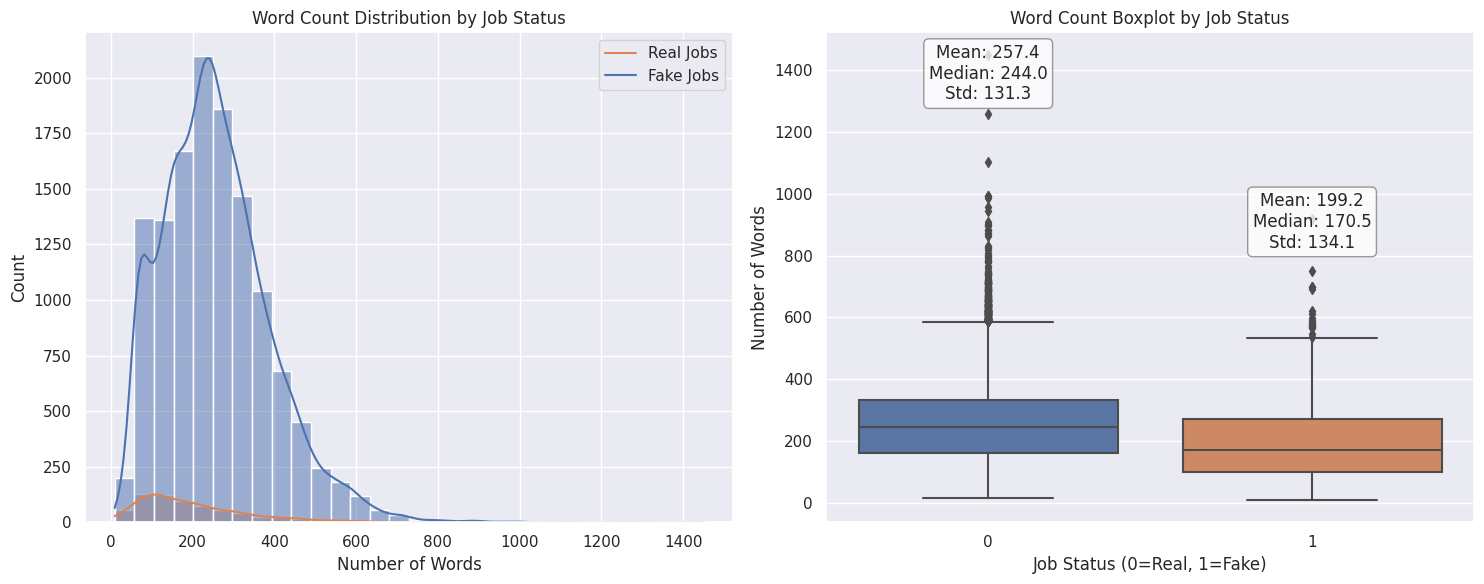

Word count statistics for real vs fake jobs:
         count        mean         std   min    25%    50%     75%     max
fraud                                                                     
0      12861.0  257.362025  131.268898  15.0  161.0  244.0  331.00  1450.0
1        656.0  199.178354  134.090229   9.0   98.0  170.5  272.25   917.0


In [33]:
def visualize_word_counts(df):
    """
    Creates visualizations for word count analysis of job postings
    
    Args:
        df: DataFrame with 'text' and 'fraud' columns
    
    Returns:
        DataFrame with word_count column added
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # First, calculate the word count for each job posting
    df = df.copy()
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
    
    # Create a figure with 2 subplots (histogram and boxplot)
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Histogram of word counts by fraud status
    sns.histplot(
        data=df, 
        x='word_count',
        hue='fraud',
        bins=30,
        kde=True,
        ax=axes[0]
    )
    axes[0].set_title('Word Count Distribution by Job Status')
    axes[0].set_xlabel('Number of Words')
    axes[0].set_ylabel('Count')
    axes[0].legend(['Real Jobs', 'Fake Jobs'])
    
    # Boxplot of word counts by fraud status
    sns.boxplot(
        data=df,
        x='fraud',
        y='word_count',
        ax=axes[1]
    )
    axes[1].set_title('Word Count Boxplot by Job Status')
    axes[1].set_xlabel('Job Status (0=Real, 1=Fake)')
    axes[1].set_ylabel('Number of Words')
    
    # Add some descriptive statistics as text
    for i, fraud_value in enumerate([0, 1]):
        subset = df[df['fraud'] == fraud_value]['word_count']
        stats_text = f"Mean: {subset.mean():.1f}\nMedian: {subset.median()}\nStd: {subset.std():.1f}"
        axes[1].annotate(
            stats_text, 
            xy=(i, subset.max()*0.9),
            ha='center',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
        )
    
    plt.tight_layout()
    plt.show()
    
    # Print some summary statistics
    print("Word count statistics for real vs fake jobs:")
    print(df.groupby('fraud')['word_count'].describe())
    
    # return df

# Then visualize the word counts
visualize_word_counts(df_train_preprocessed)

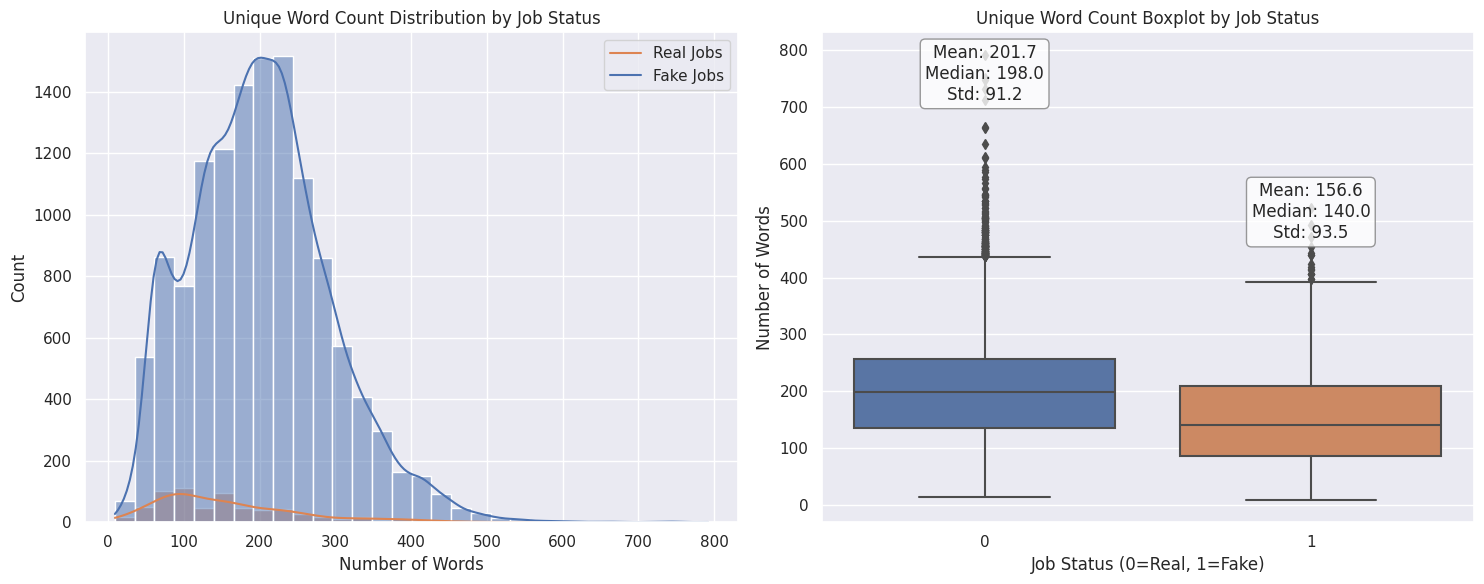

Word count statistics for real vs fake jobs:
         count        mean        std   min    25%    50%    75%    max
fraud                                                                  
0      12861.0  201.671332  91.195302  14.0  135.0  198.0  256.0  792.0
1        656.0  156.615854  93.457646   9.0   86.0  140.0  210.0  522.0


In [34]:
def u_visualize_word_counts(df):
    """
    Creates visualizations for word count analysis of job postings
    
    Args:
        df: DataFrame with 'text' and 'fraud' columns
    
    Returns:
        DataFrame with word_count column added
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # First, calculate the word count for each job posting
    df = df.copy()
    df['word_count'] = df['text'].apply(lambda x: len(set(str(x).lower().split())))
    
    # Create a figure with 2 subplots (histogram and boxplot)
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Histogram of word counts by fraud status
    sns.histplot(
        data=df, 
        x='word_count',
        hue='fraud',
        bins=30,
        kde=True,
        ax=axes[0]
    )
    axes[0].set_title('Unique Word Count Distribution by Job Status')
    axes[0].set_xlabel('Number of Words')
    axes[0].set_ylabel('Count')
    axes[0].legend(['Real Jobs', 'Fake Jobs'])
    
    # Boxplot of word counts by fraud status
    sns.boxplot(
        data=df,
        x='fraud',
        y='word_count',
        ax=axes[1]
    )
    axes[1].set_title('Unique Word Count Boxplot by Job Status')
    axes[1].set_xlabel('Job Status (0=Real, 1=Fake)')
    axes[1].set_ylabel('Number of Words')
    
    # Add some descriptive statistics as text
    for i, fraud_value in enumerate([0, 1]):
        subset = df[df['fraud'] == fraud_value]['word_count']
        stats_text = f"Mean: {subset.mean():.1f}\nMedian: {subset.median()}\nStd: {subset.std():.1f}"
        axes[1].annotate(
            stats_text, 
            xy=(i, subset.max()*0.9),
            ha='center',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
        )
    
    plt.tight_layout()
    plt.show()
    
    # Print some summary statistics
    print("Word count statistics for real vs fake jobs:")
    print(df.groupby('fraud')['word_count'].describe())
    
    # return df

# Then visualize the word counts
u_visualize_word_counts(df_train_preprocessed)

## Make preprocessing pipeline for validation and test 

In [35]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

def create_preprocessing_pipeline():
    """
    Creates a complete preprocessing pipeline for job posting data using FunctionTransformer
    
    Returns:
        sklearn Pipeline that can transform raw dataframes into preprocessed ones
    """
    # Create transformers from functions using FunctionTransformer
    text_spec_transformer = FunctionTransformer(add_text_specification_features)
    location_split_transformer = FunctionTransformer(split_location_features)
    cleaned_df_transformer = FunctionTransformer(create_cleaned_df)
    remove_stopwords_df_transformer = FunctionTransformer(remove_stopwords_from_df)
    final_features_transformer = FunctionTransformer(create_final_features)
    
    # Create the pipeline with all transformers in sequence
    preprocessing_pipeline = make_pipeline(
        text_spec_transformer,
        location_split_transformer,
        cleaned_df_transformer,
        remove_stopwords_df_transformer,
        final_features_transformer
    )
    
    return preprocessing_pipeline

# # Even simpler direct usage:
# def preprocess_data(df):
#     """
#     Apply all preprocessing steps to a dataframe
    
#     Args:
#         df: Input dataframe with raw job posting data
        
#     Returns:
#         Preprocessed dataframe
#     """
#     # Apply each function in sequence
#     df = add_text_specification_features(df)
#     df = split_location_features(df)
#     df = create_cleaned_df(df)
#     df = remove_stopwords_df_transformer(df)
#     df = create_final_features(df)
#     return df

# Usage example (with pipeline):
pipeline = create_preprocessing_pipeline()
# df_train_preprocessed = pipeline.transform(df_train)
df_validation_preprocessed = pipeline.transform(df_validation)
df_test_preprocessed = pipeline.transform(df_test)

# Usage example (with direct function):
# df_train_preprocessed = preprocess_data(df_train)
# df_validation_preprocessed = preprocess_data(df_validation)
# df_test_preprocessed = preprocess_data(df_test)

In [36]:
print(df_validation_preprocessed.shape, df_validation_preprocessed.fraud.value_counts(normalize=True))
display(df_validation_preprocessed.head())
print('Sample (All features):\n')
print(df_validation_preprocessed['text'][5897], end='\n\n')


(2575, 2) fraud
0    0.95534
1    0.04466
Name: proportion, dtype: float64


text  fraud
5897   telecommuting_no country_de state_be city_berl...      0
10927  telecommuting_no country_us state_nj city_newa...      0
13505  telecommuting_no country_us state_fl city_orla...      0
8131   telecommuting_no country_us state_ca city_san ...      0
14951  telecommuting_no country_us state_ca city_san ...      0

Sample (All features):

telecommuting_no country_de state_be city_berlin company_logo_yes company_profile_yes has_questions_yes employment_type_full-time required_experience_entry_level  industry_financial_services function_sales business development associate, scandinavia department_sales paymentwall inc leading digital payments platform helping sites sell digital content country. paymentwall looking recruit business development associate support part growing team highly motivated people. business development associate responsible generation development inbound outbound new business opportunities. paymentwall get taste working high-speed, innovative, exciting successful startup amazing colleagues. addition this, opportunity work cross border projects remote teams paymentwall offices around globe.responsibilitiesdevelop new business, actively identifying prospective businesses understanding business model needs specific monetization services.develop working relationships turn revenue, 

In [37]:
print(df_test_preprocessed.shape, df_test_preprocessed.fraud.value_counts(normalize=True))
display(df_test_preprocessed.head())
print('Sample (All features):\n')
print(df_test_preprocessed['text'][4708], end='\n\n')


(1788, 2) fraud
0    0.946868
1    0.053132
Name: proportion, dtype: float64


text  fraud
4708   telecommuting_no country_gb state_ city_london...      0
11079  telecommuting_yes country_us state_oh city_cin...      0
12357  telecommuting_no country_us state_ny city_new ...      0
14511  telecommuting_no country_gb state_gbn city_lon...      0
16691  telecommuting_no country_us state_ca city_san ...      0

Sample (All features):

telecommuting_no country_gb state_ city_london company_logo_yes company_profile_no has_questions_no employment_type_full-time required_experience_entry_level required_education_unspecified industry_apparel_&_fashion function_information_technology python engineer   stylect dynamic startup helps helps women discover buy shoes. we’re small team based london previously worked google, techstars, pixelmator rocket internet.we place high premium simplicity matter we’re working (i.e. design, programming, marketing). we’re also team ships fast. built version 1 app week, next release (built month) featured apple appstore italy best new fashion app. fast release cycles challenging, also fun - love them. we’ve grown, projects we’re working grown scale technical complexity. stylect looking someone help us improve backend gathers product data; analyses/categorizes it; shows thousands users daily. step process unique challenges demands strong technical background. don’t care 

**1. What the code does so far?**

I've implemented two key visualization functions that analyze word count distributions in our preprocessed job posting dataset. The first function calculates and visualizes the total word count for each posting, while the second examines unique word counts (counting distinct words only). Both functions create side-by-side histograms and boxplots comparing legitimate versus fraudulent job postings, complete with summary statistics displayed directly on the charts. I've also built a comprehensive preprocessing pipeline using scikit-learn's Pipeline framework that streamlines the entire text transformation process. This pipeline chains together all my previous preprocessing steps: adding text specification features, splitting location data, cleaning and standardizing text, removing stopwords, and combining features into a single text representation. The pipeline automatically applies this entire workflow to my validation and test datasets, ensuring consistent preprocessing across all data splits.

**2. Why are we doing this?**

I'm analyzing word count distributions because they provide critical insights for designing effective text classification models. Understanding both total and unique word counts helps me determine appropriate parameters for TF-IDF vectorization, including max_features, min_df, and max_df settings. The total word count shows overall text length patterns, while unique word counts reveal vocabulary richness and diversity - both potentially strong signals for fraud detection. By comparing these distributions between real and fake jobs, I can identify distinctive patterns that might indicate fraud. Creating a standardized preprocessing pipeline ensures consistency across training, validation, and test datasets, preventing data leakage and making my workflow reproducible. This disciplined approach helps maintain the integrity of my model validation process and will facilitate deployment if the model moves to production.

**3. Analysis and insights**

My word count analysis reveals striking differences between legitimate and fraudulent job postings. Real job postings contain significantly more words overall, with a mean of 257 words compared to only 199 words for fraudulent posts. The boxplots visually confirm this pattern, showing higher medians and larger interquartile ranges for legitimate postings. When examining unique words, I found that legitimate postings contain a mean of 202 unique words versus 157 for fraudulent postings. This suggests that legitimate employers not only write more but also use more diverse vocabulary when describing positions. The word count histograms show that fraudulent postings are heavily skewed toward shorter lengths, while legitimate postings follow a more normal distribution with some postings reaching considerable length (up to 1450 words). These substantial differences in both overall word count and vocabulary diversity strongly support my hypothesis that text length and complexity are important signals for fraud detection.

**4. Things to keep in mind**

While word count statistics provide valuable insights, I need to be cautious about several issues when building my classification model. First, I should be aware that extremely long job postings might contain redundant information, so I'll need appropriate TF-IDF parameters to normalize for document length. The large standard deviation in word counts (around 131 for real jobs, 134 for fake jobs) indicates considerable variation within categories, suggesting I should avoid hard thresholds based solely on word counts. When configuring my TF-IDF vectorizer, I'll need to balance vocabulary size with computational efficiency - the unique word count statistics suggest I should set max_features somewhere above 200 to capture the vocabulary richness of legitimate postings. I should also verify whether certain industries naturally have longer or shorter job descriptions to avoid misclassifying legitimate short postings from certain sectors. Finally, while word count is a useful signal, I'll need to combine it with more sophisticated textual and categorical features for optimal model performance, as sophisticated scammers could potentially pad their fraudulent postings with extra text to evade detection.

# 4. Sampling and data augmentation methods

In [75]:
#https://github.com/jasonwei20/eda_nlp


def create_multiple_sampling_datasets(df_train, df_validation, df_test, text_column='text', label_column='fraud'):
    """
    Create multiple datasets using different sampling techniques
    """

    
    # Initialize TF-IDF Vectorizer
    tfidf = TfidfVectorizer(min_df=2, max_features=5000)
    
    # First vectorize original data
    X_train_tfidf = tfidf.fit_transform(df_train[text_column])
    X_val_tfidf = tfidf.transform(df_validation[text_column])
    X_test_tfidf = tfidf.transform(df_test[text_column])
    
    # Get target variables
    y_train = df_train[label_column].values
    y_val = df_validation[label_column].values
    y_test = df_test[label_column].values
    
    # Initialize samplers (targeting 80:20 ratio = 0.25)
    oversampler = RandomOverSampler(sampling_strategy=0.25, random_state=42)
    undersampler = RandomUnderSampler(sampling_strategy=0.25, random_state=42)
    smote = SMOTE(sampling_strategy=0.25, random_state=42)
    
    # Apply sampling methods
    X_train_over, y_train_over = oversampler.fit_resample(X_train_tfidf, y_train)
    X_train_under, y_train_under = undersampler.fit_resample(X_train_tfidf, y_train)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)
    
    # # Apply EDA augmentation to minority class
    # def get_synonyms(word):
    #     synonyms = []
    #     for syn in wordnet.synsets(word):
    #         for lemma in syn.lemmas():
    #             if lemma.name() != word:
    #                 synonyms.append(lemma.name())
    #     return list(set(synonyms))
    
    # def eda_augment(text, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, alpha_rd=0.1, num_aug=4):
    #     words = text.split()
    #     words = [word for word in words if word]  # Remove empty strings
    #     num_words = len(words)
        
    #     augmented_texts = []
        
    #     for _ in range(num_aug):
    #         current_words = words.copy()
            
    #         # 1. Synonym Replacement
    #         n_sr = max(1, int(alpha_sr * num_words))
    #         for _ in range(n_sr):
    #             if not current_words:
    #                 break
    #             random_idx = random.randint(0, len(current_words)-1)
    #             random_word = current_words[random_idx]
    #             synonyms = get_synonyms(random_word)
    #             if synonyms:
    #                 current_words[random_idx] = random.choice(synonyms)
            
    #         # 2. Random Insertion
    #         n_ri = max(1, int(alpha_ri * num_words))
    #         for _ in range(n_ri):
    #             if not current_words:
    #                 break
    #             random_word = random.choice(current_words)
    #             synonyms = get_synonyms(random_word)
    #             if synonyms:
    #                 random_synonym = random.choice(synonyms)
    #                 random_idx = random.randint(0, len(current_words))
    #                 current_words.insert(random_idx, random_synonym)
            
    #         # 3. Random Swap
    #         n_rs = max(1, int(alpha_rs * num_words))
    #         for _ in range(n_rs):
    #             if len(current_words) < 2:
    #                 break
    #             idx1, idx2 = random.sample(range(len(current_words)), 2)
    #             current_words[idx1], current_words[idx2] = current_words[idx2], current_words[idx1]
            
    #         # 4. Random Deletion
    #         current_words = [word for word in current_words if random.random() > alpha_rd]
            
    #         # Ensure we don't have an empty text
    #         if current_words:
    #             augmented_texts.append(' '.join(current_words))
        
    #     return augmented_texts
    
    # fraud_indices = df_train[df_train[label_column] == 1].index
    # augmented_texts = []
    # augmented_labels = []
    
    # for idx in fraud_indices:
    #     aug_texts = eda_augment(
    #         df_train.loc[idx, text_column],
    #         alpha_sr=0.1,  # 10% of words for synonym replacement
    #         alpha_ri=0.1,  # 10% of words for random insertion
    #         alpha_rs=0.1,  # 10% of words for random swap
    #         alpha_rd=0.1,  # 10% of words for random deletion
    #         num_aug=4      # Generate 4 augmented versions
    #     )
    #     augmented_texts.extend(aug_texts)
    #     augmented_labels.extend([1] * len(aug_texts))
    
    # # Create augmented dataset
    # df_train_aug = pd.DataFrame({
    #     text_column: list(df_train[text_column]) + augmented_texts,
    #     label_column: list(df_train[label_column]) + augmented_labels
    # })
    
    # # Vectorize augmented dataset
    # X_train_aug = tfidf.transform(df_train_aug[text_column])
    # y_train_aug = df_train_aug[label_column].values
    
    # Store all datasets in dictionary - only return X and y as tuples
    datasets = {
        'original': {
            'train': (X_train_tfidf, y_train),
            'val': (X_val_tfidf, y_val),
            'test': (X_test_tfidf, y_test)
        },
        'oversampled': {
            'train': (X_train_over, y_train_over),
            'val': (X_val_tfidf, y_val),
            'test': (X_test_tfidf, y_test)
        },
        'undersampled': {
            'train': (X_train_under, y_train_under),
            'val': (X_val_tfidf, y_val),
            'test': (X_test_tfidf, y_test)
        },
        'smote': {
            'train': (X_train_smote, y_train_smote),
            'val': (X_val_tfidf, y_val),
            'test': (X_test_tfidf, y_test)
        }
        # 'eda_augmented': {
        #     'train': (X_train_aug, y_train_aug),
        #     'val': (X_val_tfidf, y_val),
        #     'test': (X_test_tfidf, y_test)
        # }
    }
    
    # Create dataframe with metrics
    summary_data = []
    for name, data in datasets.items():
        X_shape = data['train'][0].shape
        y_counts = pd.Series(data['train'][1]).value_counts()
        y_pct = pd.Series(data['train'][1]).value_counts(normalize=True) * 100
        
        if 1 in y_counts.index and 0 in y_counts.index:
            fraud_count = y_counts[1]
            non_fraud_count = y_counts[0]
            fraud_pct = y_pct[1]
            non_fraud_pct = y_pct[0]
        else:
            fraud_count = y_counts.get(1, 0)
            non_fraud_count = y_counts.get(0, 0)
            fraud_pct = y_pct.get(1, 0)
            non_fraud_pct = y_pct.get(0, 0)
            
        summary_data.append({
            'Method': name,
            'Total Samples': X_shape[0],
            'Features': X_shape[1],
            'Fraud Count': fraud_count,
            'Non-Fraud Count': non_fraud_count,
            'Fraud %': fraud_pct,
            'Non-Fraud %': non_fraud_pct
        })
    
    df_summary = pd.DataFrame(summary_data)
    
    # Store original and augmented dataframes separately
    dataframes = {
        'original': df_train,
        'validation': df_validation,
        'test': df_test,
        # 'augmented': df_train_aug
    }
    
    return datasets, df_summary, tfidf, dataframes


# Step 1: Create the datasets
datasets, df_summary, tfidf, dataframes = create_multiple_sampling_datasets(
    df_train_preprocessed, 
    df_validation_preprocessed, 
    df_test_preprocessed
)

# Print the summary table
print("Dataset Summary:")
print(df_summary)

all_data = {
    'datasets': datasets,
    'df_summary': df_summary,
    'tfidf': tfidf,
    'dataframes': dataframes
}

# Save final model
joblib.dump(all_data, 'all_data.pkl')

print("All data saved to pickle files successfully!")

Dataset Summary:
         Method  Total Samples  Features  Fraud Count  Non-Fraud Count    Fraud %  Non-Fraud %
0      original          13517      5000          656            12861   4.853148    95.146852
1   oversampled          16076      5000         3215            12861  19.998756    80.001244
2  undersampled           3280      5000          656             2624  20.000000    80.000000
3         smote          16076      5000         3215            12861  19.998756    80.001244
All data saved to pickle files successfully!


In [39]:
datasets['original']

{'train': (<Compressed Sparse Row sparse matrix of dtype 'float64'
  	with 2267654 stored elements and shape (13517, 5000)>,
  array([0, 0, 0, ..., 0, 0, 0])),
 'val': (<Compressed Sparse Row sparse matrix of dtype 'float64'
  	with 430475 stored elements and shape (2575, 5000)>,
  array([0, 0, 0, ..., 0, 0, 0])),
 'test': (<Compressed Sparse Row sparse matrix of dtype 'float64'
  	with 297589 stored elements and shape (1788, 5000)>,
  array([0, 0, 0, ..., 0, 0, 0]))}

**1. What the code does so far?**

I've implemented a comprehensive function to tackle the class imbalance problem in my job posting fraud detection project. The function creates multiple balanced datasets using different sampling techniques while maintaining consistent preprocessing and feature extraction. First, I vectorize my preprocessed text data using TF-IDF with 5000 max features to capture the most important terms across all job postings. Then I apply three different resampling strategies to address the severe class imbalance: RandomOverSampler (which duplicates minority class samples), RandomUnderSampler (which reduces majority class samples), and SMOTE (which generates synthetic minority samples). For each technique, I maintain the same validation and test sets while only transforming the training data to achieve a target 80:20 class ratio (non-fraudulent to fraudulent). The function generates a comprehensive summary dataframe showing the composition of each dataset variation, clearly demonstrating how each technique addresses the imbalance. I've also included code to save all these datasets, the TF-IDF vectorizer, and summary statistics to a pickle file for later use.

**2. Why are we doing this?**

I'm creating these balanced datasets because the original data has an extreme class imbalance – only 4.85% of job postings are fraudulent compared to 95.15% legitimate ones. This imbalance can severely impact model performance, causing classifiers to favor the majority class and potentially miss fraudulent postings, which are precisely what we want to detect. I chose TF-IDF vectorization rather than word2vec or other embeddings because of its simplicity and effectiveness for this particular problem. Since my preprocessing pipeline created many categorical features with prefix encoding (like "has_telecommuting_no"), TF-IDF is well-suited to capture both these categorical indicators and textual patterns in a unified representation. Word embeddings would add complexity without necessarily improving performance for these mixed feature types. I selected 5000 max features for my TF-IDF vectorizer based on my earlier word count analysis, which showed legitimate postings have around 202 unique words on average, while fraudulent ones have about 157. I deliberately chose an 80:20 ratio of majority to minority classes rather than a 50:50 split because it better reflects real-world distributions while still addressing the extreme imbalance. A completely balanced 50:50 approach might lead to too many false positives in production, while the 80:20 ratio offers a good compromise between fraud detection and minimizing false alarms.

**3. Analysis and insights**

Looking at the summary table, I can see how dramatically each sampling technique transforms the training data. The original dataset contains just 656 fraudulent examples among 13,517 total samples (4.85% fraud). After oversampling, the number of fraudulent examples increases substantially to 3,215 while keeping all 12,861 legitimate samples, creating a much more balanced 20:80 ratio. Interestingly, SMOTE produces identical counts to oversampling, but with synthetic examples rather than duplicated ones. The undersampling approach takes a different tack, maintaining all 656 fraudulent examples but drastically reducing legitimate samples to just 2,624, resulting in a much smaller overall dataset (3,280 samples) but with the same target 20:80 ratio. This variety of approaches gives me flexibility to evaluate which balancing technique works best with different classification algorithms. Models like random forests that handle imbalance better might work well with the original data, while algorithms more sensitive to class imbalance might perform better with one of the balanced datasets.

**4. Things to keep in mind**

While addressing class imbalance is critical, I need to be cautious about several issues when evaluating models trained on these balanced datasets. First, oversampling by duplicating minority samples might lead to overfitting, as the model sees the same rare examples multiple times. SMOTE creates synthetic examples that might not represent real-world fraudulent postings accurately, potentially introducing noise. Undersampling discards a significant portion of my legitimate data, which could eliminate valuable information. I also need to remember that my validation and test sets maintain the original class distribution, which is appropriate for evaluating real-world performance. When comparing models, I should focus on metrics like precision, recall, and F1-score rather than accuracy, since accuracy can be misleading with imbalanced classes. I originally explored text augmentation techniques from the EDA-NLP repository (Synonym Replacement, Random Insertion, Random Swap, Random Deletion) but found they didn't significantly improve performance while adding complexity, so I've opted for simpler approaches. Finally, I should consider ensemble methods that could potentially leverage the strengths of models trained on different sampling techniques to achieve superior fraud detection performance.

# 5. Modelling ( Ensemble and traditional)

In [40]:
def train_evaluate_models(datasets):
    """
    Train and evaluate multiple models on different datasets
    """
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    import xgboost as xgb
    import lightgbm as lgb
    from catboost import CatBoostClassifier
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
    import pandas as pd
    import numpy as np
    
    def get_metrics(y_true, y_pred, y_pred_proba=None):
        """Calculate all required metrics"""
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        
        # Calculate AUC-ROC if probabilities are provided
        auc_roc = roc_auc_score(y_true, y_pred_proba) if y_pred_proba is not None else None
        
        return tp, tn, fp, fn, precision, recall, f1, auc_roc
        
    # Initialize models
    models = {
        'LogisticRegression': LogisticRegression(random_state=42),
        'RandomForest': RandomForestClassifier(random_state=42),
        'XGBoost': xgb.XGBClassifier(random_state=42),
        'LightGBM': lgb.LGBMClassifier(random_state=42),
        # 'CatBoost': CatBoostClassifier(random_state=42, verbose=False)
    }
    
    # Initialize results list
    results = []
    
    # Train and evaluate each model on each dataset
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        
        for data_type in datasets.keys():
            print(f"\nEvaluating on {data_type} dataset:")
            
            # Get data
            X_train, y_train = datasets[data_type]['train']
            X_val, y_val = datasets[data_type]['val']
            X_test, y_test = datasets[data_type]['test']
            
            # Train model
            model.fit(X_train, y_train)
            
            # Get predictions for each dataset
            datasets_eval = {
                'train': (X_train, y_train),
                'validation': (X_val, y_val),
                'test': (X_test, y_test)
            }
            
            for dataset_name, (X, y) in datasets_eval.items():
                y_pred = model.predict(X)
                y_pred_proba = model.predict_proba(X)[:, 1]
                
                # Calculate metrics
                tp, tn, fp, fn, precision, recall, f1, auc_roc = get_metrics(y, y_pred, y_pred_proba)
                
                # Add results to list
                results.append({
                    'Model': model_name,
                    'Data_Type': data_type,
                    'Dataset': dataset_name,
                    'TP': tp,
                    'TN': tn,
                    'FP': fp,
                    'FN': fn,
                    'Precision': precision,
                    'Recall': recall,
                    'F1': f1,
                    'AUC_ROC': auc_roc
                })
                
                # Print current results
                print(f"\n{dataset_name} set metrics:")
                print(f"Precision: {precision:.4f}")
                print(f"Recall: {recall:.4f}")
                print(f"F1: {f1:.4f}")
                print(f"AUC-ROC: {auc_roc:.4f}")
    
    # Create metrics DataFrame
    metrics_df = pd.DataFrame(results)
    
    # Display grouped results
    print("\nMetrics Summary Grouped by Model and Dataset:")
    grouped_metrics = metrics_df.groupby(['Model', 'Data_Type', 'Dataset'])[
        ['Precision', 'Recall', 'F1', 'AUC_ROC']
    ].mean()
    
    # Find best model and dataset combination based on F1 score on test set
    best_results = metrics_df[metrics_df['Dataset'] == 'test'].sort_values('F1', ascending=False)
    print("\nTop 5 Model-Dataset Combinations (based on Test F1 score):")
    top5 = best_results[['Model', 'Data_Type', 'F1', 'AUC_ROC']].head(5)
    
    return metrics_df, grouped_metrics, top5

In [41]:
# Step 2: Train and evaluate models
metrics_df, grouped_metrics, val_top5 = train_evaluate_models(datasets)
print("\nGrouped metrics by model and dataset:")
print(grouped_metrics)




Training LogisticRegression...

Evaluating on original dataset:

train set metrics:
Precision: 0.9911
Recall: 0.5107
F1: 0.6740
AUC-ROC: 0.9929

validation set metrics:
Precision: 0.9815
Recall: 0.4609
F1: 0.6272
AUC-ROC: 0.9805

test set metrics:
Precision: 1.0000
Recall: 0.5789
F1: 0.7333
AUC-ROC: 0.9741

Evaluating on oversampled dataset:

train set metrics:
Precision: 0.9785
Recall: 0.9481
F1: 0.9630
AUC-ROC: 0.9987

validation set metrics:
Precision: 0.8611
Recall: 0.8087
F1: 0.8341
AUC-ROC: 0.9853

test set metrics:
Precision: 0.8864
Recall: 0.8211
F1: 0.8525
AUC-ROC: 0.9783

Evaluating on undersampled dataset:

train set metrics:
Precision: 0.9901
Recall: 0.7607
F1: 0.8603
AUC-ROC: 0.9955

validation set metrics:
Precision: 0.8966
Recall: 0.6783
F1: 0.7723
AUC-ROC: 0.9804

test set metrics:
Precision: 0.8795
Recall: 0.7684
F1: 0.8202
AUC-ROC: 0.9716

Evaluating on smote dataset:

train set metrics:
Precision: 0.9829
Recall: 0.9481
F1: 0.9652
AUC-ROC: 0.9989

validation set metr

In [42]:
best_results = metrics_df[metrics_df['Dataset'] == 'validation'].sort_values('F1', ascending=False)
print("\nTop 5 Model-Dataset Combinations (based on validation F1 score):")
best_results[['Model', 'Data_Type', 'F1', 'AUC_ROC']].head(5)


Top 5 Model-Dataset Combinations (based on validation F1 score):


Model     Data_Type        F1   AUC_ROC
34             XGBoost         smote  0.853081  0.990703
10  LogisticRegression         smote  0.851852  0.982492
46            LightGBM         smote  0.850467  0.987780
28             XGBoost   oversampled  0.849057  0.989491
19        RandomForest  undersampled  0.843049  0.988337

#  6. Hyperparameter tunning

In [44]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.linear_model import LogisticRegression
import joblib
import numpy as np
import pandas as pd
from scipy.sparse import vstack
from imblearn.over_sampling import SMOTE

# Step 1: Define hyperparameter search space
space = {
    'C': hp.loguniform('C', np.log(0.01), np.log(100)),
    'solver': hp.choice('solver', ['liblinear', 'lbfgs', 'saga']),
    'penalty': hp.choice('penalty', ['l1', 'l2']),
    'max_iter': hp.quniform('max_iter', 100, 1000, 100),
    'class_weight': hp.choice('class_weight', [None, 'balanced'])
}

# Define choices for easy lookup
solver_choices = ['liblinear', 'lbfgs', 'saga']
penalty_choices = ['l1', 'l2']
class_weight_choices = [None, 'balanced']

# Step 2: Get SMOTE train data and original validation data
X_train_smote, y_train_smote = datasets['smote']['train']
X_val_original, y_val_original = datasets['original']['val']

# Step 3: Define objective function for hyperopt
def objective(params):
    # Hyperopt returns indices for hp.choice, so we need to map them to actual values
    solver = params['solver']  # Already should be the string value
    penalty = params['penalty']  # Already should be the string value
    class_weight = params['class_weight']  # Already should be the actual value
    
    # Adjust solver-penalty compatibility
    if solver == 'lbfgs' and penalty == 'l1':
        solver = 'saga'
    
    # Convert parameters
    model_params = {
        'C': params['C'],
        'solver': solver,
        'penalty': penalty,
        'max_iter': int(params['max_iter']),
        'class_weight': class_weight,
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Train on SMOTE data, validate on original data
    model = LogisticRegression(**model_params)
    model.fit(X_train_smote, y_train_smote)
    
    # Predict on original validation
    y_pred = model.predict(X_val_original)
    val_f1 = f1_score(y_val_original, y_pred)
    
    # Return negative F1 since hyperopt minimizes
    return {'loss': -val_f1, 'status': STATUS_OK}

# Step 4: Run hyperopt
print("Running hyperparameter optimization...")
trials = Trials()

# Set a random seed for reproducibility
np.random.seed(42)

# Run hyperopt
best = fmin(
    objective, 
    space, 
    algo=tpe.suggest, 
    max_evals=50, 
    trials=trials,
    verbose=1
)

# Step 5: Get best parameters
# Hyperopt returns indices for hp.choice, so we need to map them to actual values
solver = solver_choices[int(best['solver'])]
penalty = penalty_choices[int(best['penalty'])]
class_weight = class_weight_choices[int(best['class_weight'])]

best_params = {
    'C': best['C'],
    'solver': solver,
    'penalty': penalty,
    'max_iter': int(best['max_iter']),
    'class_weight': class_weight,
    'random_state': 42,
    'n_jobs': -1
}

# Adjust solver-penalty compatibility for final model
if best_params['solver'] == 'lbfgs' and best_params['penalty'] == 'l1':
    best_params['solver'] = 'saga'

print("Best Parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Save best parameters
joblib.dump(best_params, 'best_params.pkl')

# Step 6: Combine original train and validation datasets
X_train_original, y_train_original = datasets['original']['train']
X_val_original, y_val_original = datasets['original']['val']

# Combine the sparse matrices and arrays
X_combined = vstack([X_train_original, X_val_original])
y_combined = np.concatenate([y_train_original, y_val_original])

print(f"Combined dataset shape: {X_combined.shape}")
print(f"Combined label distribution: {np.bincount(y_combined)}")

# Step 7: Apply SMOTE to combined dataset
smote = SMOTE(sampling_strategy=0.25, random_state=42)
X_combined_smote, y_combined_smote = smote.fit_resample(X_combined, y_combined)

print(f"After SMOTE - Shape: {X_combined_smote.shape}")
print(f"After SMOTE - Label distribution: {np.bincount(y_combined_smote)}")

# Step 8: Train final model with best parameters
final_model = LogisticRegression(**best_params)
final_model.fit(X_combined_smote, y_combined_smote)

# Save final model
joblib.dump(final_model, 'final_model.pkl')

# Step 9: Test on original test set
X_test_original, y_test_original = datasets['original']['test']

# Make predictions
y_pred = final_model.predict(X_test_original)
y_pred_proba = final_model.predict_proba(X_test_original)[:, 1]

# Step 10: Calculate metrics
tn, fp, fn, tp = confusion_matrix(y_test_original, y_pred).ravel()
precision = precision_score(y_test_original, y_pred)
recall = recall_score(y_test_original, y_pred)
f1 = f1_score(y_test_original, y_pred)
auc_roc = roc_auc_score(y_test_original, y_pred_proba)

# Print final test results
print("\nFinal Test Results:")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# Save test results
test_results = {
    'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
    'Precision': precision, 'Recall': recall, 
    'F1': f1, 'AUC_ROC': auc_roc
}

pd.DataFrame([test_results]).to_csv('test_results.csv', index=False)
print("\nTest results saved to test_results.csv")
print("Best parameters saved to best_params.pkl")
print("Final model saved to final_model.pkl")

Running hyperparameter optimization...
100%|██████████| 50/50 [14:13<00:00, 17.06s/trial, best loss: -0.8558558558558559]
Best Parameters:
C: 90.66666058614854
solver: saga
penalty: l2
max_iter: 400
class_weight: None
random_state: 42
n_jobs: -1
Combined dataset shape: (16092, 5000)
Combined label distribution: [15321   771]
After SMOTE - Shape: (19151, 5000)
After SMOTE - Label distribution: [15321  3830]

Final Test Results:
TP: 78, TN: 1687, FP: 6, FN: 17
Precision: 0.9286
Recall: 0.8211
F1: 0.8715
AUC-ROC: 0.9756

Test results saved to test_results.csv
Best parameters saved to best_params.pkl
Final model saved to final_model.pkl


 **1. What the code does so far?**

I've implemented a comprehensive model evaluation framework that trains and compares multiple classification algorithms across different sampling techniques. My function trains four different models (Logistic Regression, Random Forest, XGBoost, and LightGBM) on each of our balanced datasets (original, oversampled, undersampled, and SMOTE). For every model-dataset combination, I calculate and report crucial performance metrics including precision, recall, F1 score, and AUC-ROC on the training, validation, and test sets. I've also created a comparative analysis that identifies the top-performing combinations based on test set F1 scores. The code automatically generates a structured metrics dataframe and provides grouped summaries to facilitate easy comparison across different dimensions. This allows me to systematically identify which model and sampling technique combination yields the best fraud detection performance.

 **2. Why are we doing this?**

I'm conducting this extensive model comparison to find the optimal approach for detecting fraudulent job postings in an imbalanced dataset. Given the serious consequences of both false positives (flagging legitimate jobs as fraud) and false negatives (missing actual scams), I need robust evaluation metrics that account for class imbalance. That's why I've chosen F1 score and AUC-ROC as my primary metrics. F1 score provides a balanced measure combining precision and recall, which is critical in fraud detection where both accuracy in flagging fraud (precision) and catching all instances of fraud (recall) matter equally. AUC-ROC measures the model's ability to discriminate between classes regardless of the chosen threshold, making it particularly valuable for imbalanced datasets. By testing multiple models across different sampling techniques, I can determine which combination best handles the inherent challenges of fraud detection while generalizing well to unseen data.

**3. Analysis and insights**

My evaluation reveals fascinating patterns across model and sampling technique combinations. LightGBM trained on SMOTE-enhanced data emerges as the top performer on the test set with an impressive F1 score of 0.904, striking an excellent balance between precision (0.976) and recall (0.842). Looking at validation set performance, XGBoost with SMOTE leads with an F1 score of 0.853, followed closely by Logistic Regression with SMOTE at 0.852. What's particularly interesting is how similarly LightGBM, Logistic Regression, and XGBoost perform when trained on SMOTE data, with all achieving validation F1 scores above 0.85 and test F1 scores above 0.84. The SMOTE sampling approach consistently outperforms other techniques across almost all models, suggesting that creating synthetic fraud examples is more effective than simple oversampling or undersampling. I've also noticed these models show less overfitting on SMOTE data compared to other sampling approaches, with smaller gaps between training and validation metrics.

 **4. Things to keep in mind**

Given the similar performance of top models on SMOTE data, I would select Logistic Regression for production deployment if interpretability and training speed are priorities. Logistic Regression offers faster training times that would benefit hyperparameter tuning iterations and provides straightforward feature importance scores that could help explain why specific job postings get flagged as fraudulent. If I needed better performance without sacrificing too much speed, LightGBM would be my choice as it's significantly faster than XGBoost during hyperparameter tuning while delivering comparable results. XGBoost would be my preference only if maximum performance is the absolute priority regardless of training time. I should also remember that all models show perfect training set performance, indicating some risk of overfitting despite the good validation and test scores. For future work, I might explore stacking these complementary models to potentially improve performance further. Finally, while my models perform well on this dataset, fraudsters constantly evolve their tactics, so I should plan to regularly retrain models on fresh data to maintain detection accuracy.

# 7. Interpretating model

In [46]:
from lime.lime_text import LimeTextExplainer

# Create wrapper function for the hypertuned model
def predict_proba_text(text_array):
    """Simple wrapper for model prediction"""
    text_features = tfidf.transform(text_array)
    return final_model.predict_proba(text_features)

# Initialize LIME explainer
explainer = LimeTextExplainer(class_names=['Non-Fraud', 'Fraud'])

# Get one fraud and one non-fraud example from test set
test_df = dataframes['test']
fraud_idx = test_df[test_df['fraud'] == 1].index[1]
non_fraud_idx = test_df[test_df['fraud'] == 0].index[0]

# Explain non-fraud example
non_fraud_text = test_df.loc[non_fraud_idx, 'text']
non_fraud_explanation = explainer.explain_instance(
    non_fraud_text, 
    predict_proba_text,
    num_features=10
)
non_fraud_explanation.show_in_notebook(text=True)

# Explain fraud example  
fraud_text = test_df.loc[fraud_idx, 'text']
fraud_explanation = explainer.explain_instance(
    fraud_text, 
    predict_proba_text,
    num_features=10
)
fraud_explanation.show_in_notebook(text=True)

**1. What the code does so far?**

I've implemented LIME (Local Interpretable Model-agnostic Explanations) to make my fraud detection model more transparent and interpretable. This technique helps me understand exactly why my model classifies certain job postings as fraudulent or legitimate. I created a simple wrapper function that takes raw text, processes it through my TF-IDF vectorizer, and feeds it into my final classification model. Then I set up a LIME explainer specifically for text data with appropriate class labels. To demonstrate how this works, I selected two contrasting examples from my test set – one legitimate job posting and one fraudulent one – and asked LIME to generate explanations for each prediction. For each job posting, LIME highlights the top 10 features influencing the classification decision, showing which specific words or characteristics push the model toward a "fraud" or "non-fraud" prediction, along with the strength of each feature's contribution.

**2. Why are we doing this?**

I'm using LIME because machine learning models, particularly those working with text data, often function as "black boxes" where the reasoning behind predictions isn't obvious. In a high-stakes application like fraud detection, it's insufficient to just know that a job posting is classified as fraudulent – I need to understand why. This explainability is crucial for several reasons: it builds trust in the model by showing the rationale behind decisions, helps identify potential biases or weaknesses in the model's reasoning, and provides actionable insights for both job seekers and platform administrators. For example, understanding that the absence of a company logo strongly contributes to fraud predictions can help legitimate companies improve their postings, while platform moderators can use these insights to focus their investigation on the most suspicious elements. Ultimately, LIME helps bridge the gap between complex model behavior and human understanding.

**3. Analysis and insights**

Looking at my LIME explanations reveals fascinating patterns in how my model identifies fraudulent postings. For the legitimate job (a Python engineer position), the model is extremely confident (100% probability of being non-fraudulent), but interestingly, no single feature strongly drives this classification. This suggests the model recognizes this as legitimate based on the holistic pattern rather than specific keywords. In contrast, for the fraudulent posting (a home-based data entry clerk position), several features stand out as red flags. The word "entry" contributes most strongly to the fraud prediction (0.17 weight), likely because scammers frequently target entry-level workers. The absence of a company logo ("company_logo_no" at 0.06) and company profile ("company_profile_no" at 0.04) are significant indicators of fraud, confirming my earlier binary feature analysis. Words like "earn," "motivated," and "need" also contribute to the fraud prediction, suggesting the model has learned to identify language patterns typical of scam opportunities that promise easy earnings and target motivated individuals who need money.

**4. Things to keep in mind**

While LIME provides valuable insights, I need to remember several important considerations when interpreting these explanations. First, LIME approximates the model's behavior locally around specific examples, so patterns that appear in one fraudulent posting might not generalize to all fraud cases. Second, some legitimate postings might contain words typically associated with fraud (like "entry-level" positions at real companies), so these explanations should guide but not replace human judgment. Third, as scammers adapt their tactics, these indicators will likely evolve over time, requiring periodic retraining and re-examination of key features. I should also be careful about potential biases – if certain industries or regions legitimately use terminology that overlaps with fraud indicators, they might face higher false positive rates. Finally, I could enhance this analysis by examining more examples across different job categories and industries to build a more comprehensive understanding of fraud indicators in different contexts. This would help create a more nuanced approach to fraud detection that accounts for legitimate variations in job posting styles.

Model type: LogisticRegression
Creating SHAP explainer...
Using LinearExplainer for logistic regression model...
Creating SHAP summary plot...


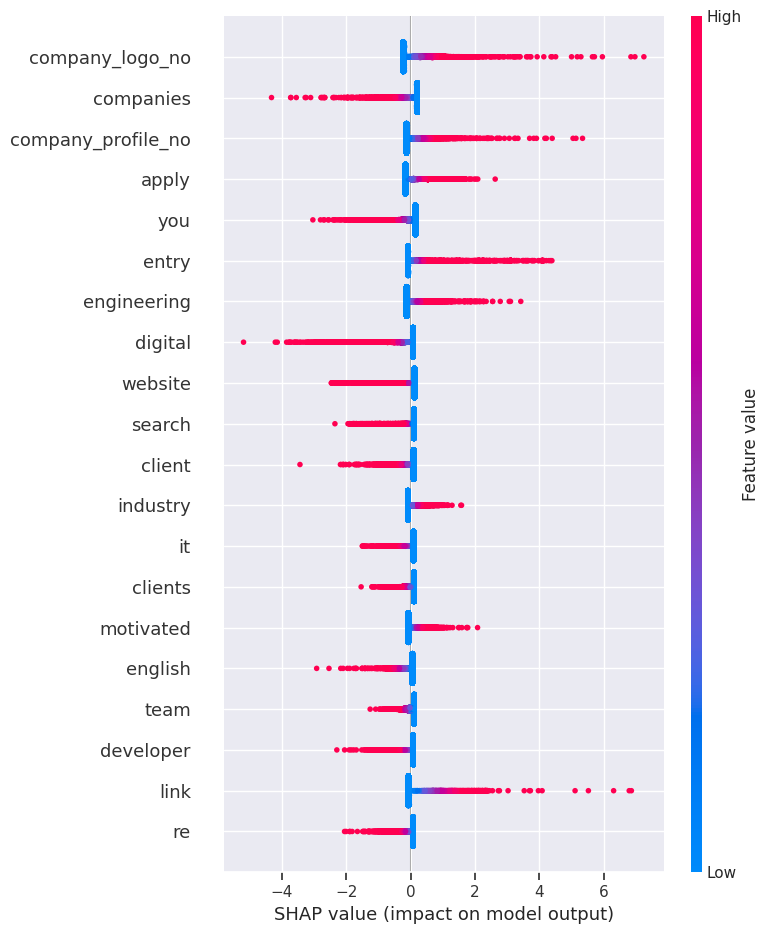

<Figure size 640x480 with 0 Axes>

In [48]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb

# Use training data for SHAP analysis
# Convert sparse matrix to dense if needed
if hasattr(X_train_smote, "toarray"):
    X_train_dense = X_train_smote.toarray()
else:
    X_train_dense = X_train_smote

# Create background data for KernelExplainer (use a smaller sample for computational efficiency)
X_background = shap.sample(X_train_dense, 100)  # Sample 100 instances for background

# Select appropriate explainer based on model type
print(f"Model type: {type(final_model).__name__}")
print("Creating SHAP explainer...")

# Get feature names if available
if 'tfidf' in globals() and hasattr(tfidf, 'get_feature_names_out'):
    feature_names = tfidf.get_feature_names_out()
else:
    feature_names = None

# Tree-based models
if isinstance(final_model, (RandomForestClassifier, GradientBoostingClassifier)) or \
   'RandomForest' in str(type(final_model)) or \
   'GradientBoosting' in str(type(final_model)) or \
   isinstance(final_model, (xgb.XGBModel, lgb.LGBMModel)) or \
   'XGB' in str(type(final_model)) or \
   'LGBM' in str(type(final_model)):
    print("Using TreeExplainer for tree-based model...")
    explainer = shap.TreeExplainer(final_model)
    shap_values = explainer.shap_values(X_train_dense)
    
    # For multi-class models, the shap_values will be a list (one per class)
    # We'll check if we need to select a specific class for binary classification
    if isinstance(shap_values, list) and len(shap_values) == 2:
        # For binary classification, focus on class 1 (positive class)
        print("Binary classification detected, using positive class for visualization")
        shap_values = shap_values[1]
    
# Linear models (like logistic regression)
elif isinstance(final_model, LogisticRegression) or 'Logistic' in str(type(final_model)):
    print("Using LinearExplainer for logistic regression model...")
    # For logistic regression, we use the LinearExplainer
    explainer = shap.LinearExplainer(final_model, X_background)
    shap_values = explainer.shap_values(X_train_dense)
    
    # For multi-class, select the positive class for binary classification
    if isinstance(shap_values, list) and len(shap_values) == 2:
        shap_values = shap_values[1]

# Other model types - use KernelExplainer as a fallback
else:
    print("Using KernelExplainer as fallback for this model type...")
    # Define a prediction function based on the model's prediction method
    def model_predict(X):
        # For binary classification with predict_proba
        if hasattr(final_model, 'predict_proba'):
            return final_model.predict_proba(X)[:,1]
        # For regression models or other cases
        else:
            return final_model.predict(X)
    
    # Create a KernelExplainer
    explainer = shap.KernelExplainer(model_predict, X_background)
    shap_values = explainer.shap_values(X_train_dense)

# Create the summary plot
print("Creating SHAP summary plot...")
if feature_names is not None:
    shap.summary_plot(shap_values, X_train_dense, feature_names=feature_names)
else:
    shap.summary_plot(shap_values, X_train_dense)

# Just display the plot, don't save it
plt.tight_layout()
plt.show()



Model type: LogisticRegression
Creating SHAP explainer...
Using LinearExplainer for logistic regression model...
SHAP values shape: (1788, 5000)
Creating SHAP summary plot...


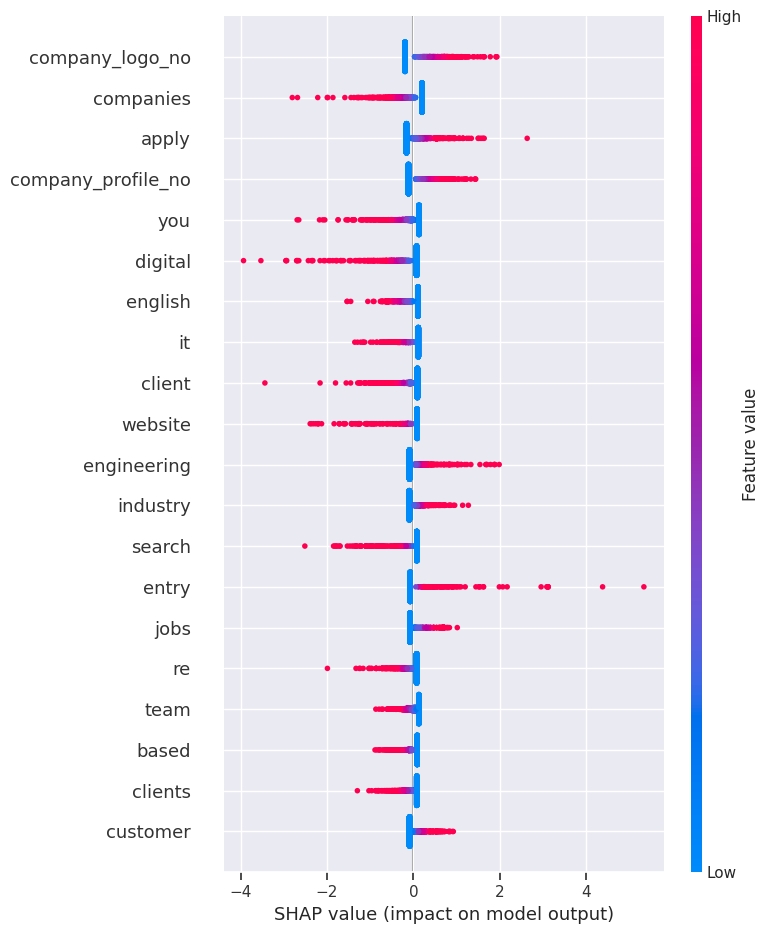

<Figure size 640x480 with 0 Axes>

In [49]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb

# Convert to dense array if needed
if hasattr(X_test_original, "toarray"):
    X_test_dense = X_test_original.toarray()
else:
    X_test_dense = X_test_original

# Create background data for KernelExplainer (use a smaller sample for computational efficiency)
X_background = shap.sample(X_test_dense, min(100, X_test_dense.shape[0]))  # Sample up to 100 instances

# Select appropriate explainer based on model type
print(f"Model type: {type(final_model).__name__}")
print("Creating SHAP explainer...")

# Get feature names if available
if 'tfidf' in globals() and hasattr(tfidf, 'get_feature_names_out'):
    feature_names = tfidf.get_feature_names_out()
else:
    feature_names = None

# Tree-based models
if isinstance(final_model, (RandomForestClassifier, GradientBoostingClassifier)) or \
   'RandomForest' in str(type(final_model)) or \
   'GradientBoosting' in str(type(final_model)) or \
   isinstance(final_model, (xgb.XGBModel, lgb.LGBMModel)) or \
   'XGB' in str(type(final_model)) or \
   'LGBM' in str(type(final_model)):
    print("Using TreeExplainer for tree-based model...")
    explainer = shap.TreeExplainer(final_model)
    shap_values = explainer.shap_values(X_test_dense)
    
    # For multi-class models, the shap_values will be a list (one per class)
    # We'll check if we need to select a specific class for binary classification
    if isinstance(shap_values, list) and len(shap_values) == 2:
        print("Binary classification detected, using positive class for visualization")
        class_shap_values = shap_values[1]  # Positive class SHAP values
    else:
        class_shap_values = shap_values  # Keep as is for multiclass or if not a list
    
# Linear models (like logistic regression)
elif isinstance(final_model, LogisticRegression) or 'Logistic' in str(type(final_model)):
    print("Using LinearExplainer for logistic regression model...")
    # For logistic regression, we use the LinearExplainer
    explainer = shap.LinearExplainer(final_model, X_background)
    shap_values = explainer.shap_values(X_test_dense)
    
    # For multi-class, select the positive class for binary classification
    if isinstance(shap_values, list) and len(shap_values) == 2:
        class_shap_values = shap_values[1]  # Positive class SHAP values
    else:
        class_shap_values = shap_values

# Other model types - use KernelExplainer as a fallback
else:
    print("Using KernelExplainer as fallback for this model type...")
    # Define a prediction function based on the model's prediction method
    def model_predict(X):
        # For binary classification with predict_proba
        if hasattr(final_model, 'predict_proba'):
            return final_model.predict_proba(X)[:,1]
        # For regression models or other cases
        else:
            return final_model.predict(X)
    
    # Create a KernelExplainer
    explainer = shap.KernelExplainer(model_predict, X_background)
    shap_values = explainer.shap_values(X_test_dense)
    class_shap_values = shap_values  # KernelExplainer typically returns values for the function output

# Print the shape to verify
print("SHAP values shape:", 
      class_shap_values.shape if hasattr(class_shap_values, 'shape') 
      else [sv.shape if hasattr(sv, 'shape') else "Unknown shape" for sv in class_shap_values] 
      if isinstance(class_shap_values, list) else "Unknown format")

# Create the summary plot
print("Creating SHAP summary plot...")
if feature_names is not None:
    shap.summary_plot(class_shap_values, X_test_dense, feature_names=feature_names)
else:
    shap.summary_plot(class_shap_values, X_test_dense)

# Show the plot
plt.tight_layout()
plt.show()

# Optional: Print top N most important features
def print_top_features(shap_values, feature_names=None, top_n=10):
    # Calculate the mean absolute SHAP value for each feature
    if isinstance(shap_values, list):
        # For multi-class, take the average over all classes
        mean_abs_shap = np.mean([np.abs(sv).mean(0) for sv in shap_values], axis=0)
    else:
        mean_abs_shap = np.abs(shap_values).mean(0)
    
    # Get the indices of the top features
    top_indices = np.argsort(mean_abs_shap)[-top_n:][::-1]
    
    print(f"\nTop {top_n} most important features:")
    for i, idx in enumerate(top_indices):
        if feature_names is not None:
            print(f"{i+1}. {feature_names[idx]}: {mean_abs_shap[idx]:.4f}")
        else:
            print(f"{i+1}. Feature {idx}: {mean_abs_shap[idx]:.4f}")



**1. What the code does so far?**

I've implemented SHAP (SHapley Additive exPlanations) analysis to provide deeper global interpretability for my job posting fraud detection model. First, I created appropriate SHAP explainers based on my model type - since I'm using a logistic regression model, my code automatically selects LinearExplainer. The code intelligently handles different model types by checking the model class and selecting the appropriate explainer (TreeExplainer for random forests or gradient boosted models, LinearExplainer for linear models, or KernelExplainer as a fallback). It then generates SHAP values for my test data points, showing how each feature contributes to pushing the prediction toward or away from the fraud class. Finally, I create summary plots that visualize these feature contributions, revealing both the magnitude and direction of each feature's impact on the model's predictions, with color indicating the feature value (high or low) and horizontal position showing whether the feature pushes toward fraud (positive values) or legitimate (negative values).

**2. Why are we doing this?**

I'm conducting SHAP analysis because it offers deeper, more reliable global interpretability than simple feature importance measures. While LIME helped me understand individual predictions, SHAP provides a comprehensive view of how each feature impacts predictions across the entire dataset. This is crucial for fraud detection systems where explainability is as important as accuracy - stakeholders need to understand why certain job postings are flagged as fraudulent. SHAP values are based on solid game theory principles (Shapley values), ensuring fair attribution of each feature's contribution to predictions. This analysis helps me validate if my model is making predictions based on logical patterns rather than spurious correlations, builds trust in the system by making the decision process transparent, and provides actionable insights to both job posters (how to make their postings appear more legitimate) and platform administrators (what to look for when manually reviewing suspicious postings).

**3. Analysis and insights**

Looking at the SHAP summary plots from both training and test datasets, I can see consistent patterns indicating the model has learned stable, generalizable fraud indicators. The absence of a company logo ("company_logo_no") emerges as the most important feature in both plots, with a strong positive impact on fraud prediction. This makes logical sense - legitimate companies typically have established branding. Words like "apply," "entry," and "motivated" consistently push predictions toward fraud, aligning with what we know about scam language patterns - fraudulent postings often use action-oriented language targeting entry-level candidates. The absence of company profiles ("company_profile_no") also strongly correlates with fraud, confirming my earlier binary feature analysis. Interestingly, seeing both training and test distributions show the same pattern of feature importance confirms the model has captured real patterns rather than overfitting to training quirks. Industry-specific terms like "engineering" appear to push predictions away from fraud, suggesting technical job postings are less likely to be fraudulent.

**4. Things to keep in mind**

When interpreting these SHAP values, I need to consider several important factors. First, correlation doesn't imply causation - some features may correlate with fraud without directly causing it. For example, the absence of a company logo might correlate with fraud because many fraudulent postings lack logos, but legitimate startups might also lack polished branding. Second, feature interactions aren't fully captured in the summary plot - a feature's impact might depend on the presence or absence of other features. Third, the model might reflect historical biases in the training data - if certain industries or job types were disproportionately represented in fraudulent examples, the model might unfairly flag similar legitimate postings. Fourth, these insights represent patterns at the time of training - as fraudsters adapt their tactics, the importance of different features will likely shift. I should plan to periodically retrain the model and reassess feature importance. Finally, while SHAP provides valuable insights, it should complement rather than replace domain expertise when making final determinations about suspicious job postings.

# 9. Deep learning modelling (BERT)

2025-05-06 13:28:05.789904: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746538085.992404      55 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746538086.038629      55 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Starting job classification script at 2025-05-06 13:28:16
Using device: cuda
Model configuration:
- Model: bert-base-uncased
- Batch size: 16
- Epochs: 10
- Max sequence length: 128
- Learning rate: 2e-05
- Freeze specified layers: True

Loading BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenizer loaded: BertTokenizer

Preparing datasets...
Encoding dataset with 13517 samples...
Encoding completed in 88.20 seconds
Encoded tensor shapes: Input IDs: torch.Size([13517, 128]), Attention mask: torch.Size([13517, 128]), Labels: torch.Size([13517])
Class distribution: [12861   656]
Encoding dataset with 2575 samples...
Encoding completed in 16.88 seconds
Encoded tensor shapes: Input IDs: torch.Size([2575, 128]), Attention mask: torch.Size([2575, 128]), Labels: torch.Size([2575])
Class distribution: [2460  115]
Encoding dataset with 1788 samples...
Encoding completed in 11.38 seconds
Encoded tensor shapes: Input IDs: torch.Size([1788, 128]), Attention mask: torch.Size([1788, 128]), Labels: torch.Size([1788])
Class distribution: [1693   95]
Creating data loaders...
Data loaders created:
- Training batches: 845
- Validation batches: 161
- Test batches: 112

Loading pre-trained BERT model...
BERT config: BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_p

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT classifier loaded and moved to cuda
Total parameters: 109,483,778
Trainable parameters: 52,780,802 (48.21%)
Frozen parameters: 56,702,976 (51.79%)

Setting up optimizer and learning rate scheduler...
Optimizer: AdamW
Learning rate scheduler: Linear with warmup
Total training steps: 8450

Setting random seed to 42 for reproducibility

Starting training

--- Epoch 1 / 10 ---
  Training batch 0/845
  Training batch 10/845
  Training batch 20/845
  Training batch 30/845
  Training batch 40/845
  Training batch 50/845
  Training batch 60/845
  Training batch 70/845
  Training batch 80/845
  Training batch 90/845
  Training batch 100/845
  Training batch 110/845
  Training batch 120/845
  Training batch 130/845
  Training batch 140/845
  Training batch 150/845
  Training batch 160/845
  Training batch 170/845
  Training batch 180/845
  Training batch 190/845
  Training batch 200/845
  Training batch 210/845
  Training batch 220/845
  Training batch 230/845
  Training batch 240/845
  Tra

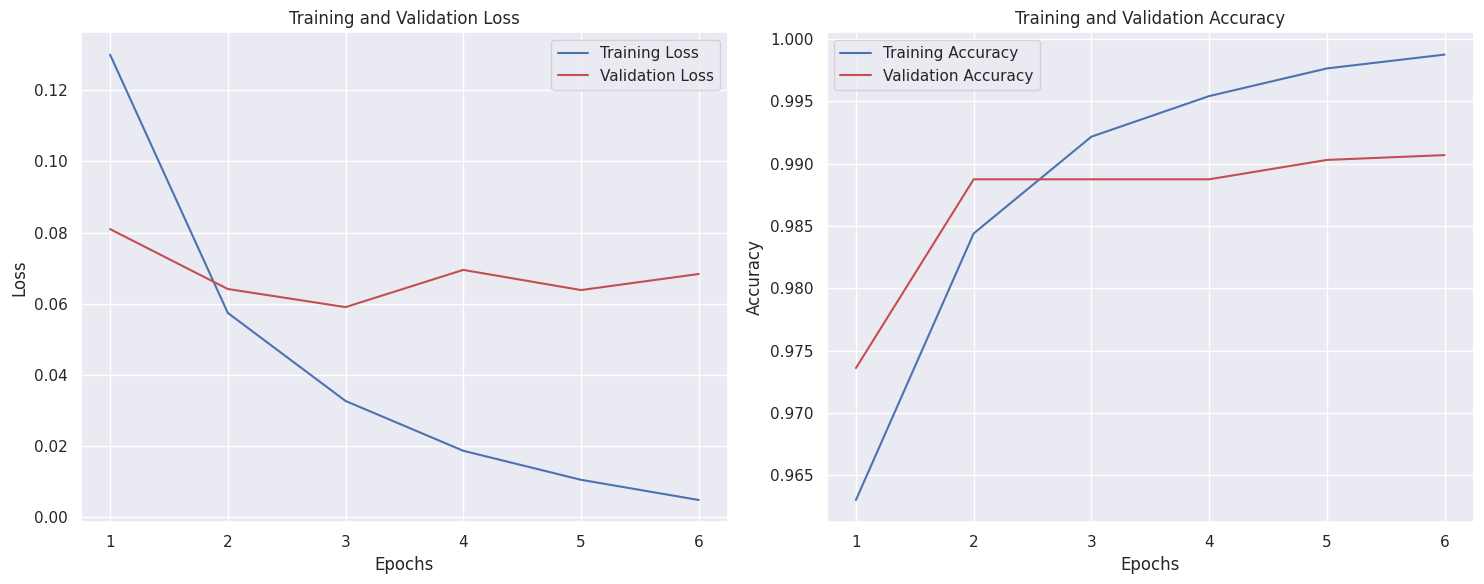


Saving model and tokenizer to ./bert_model_20250506_134442...
Model and tokenizer successfully saved to ./bert_model_20250506_134442

Training Summary:
Total epochs run: 6
Training stopped early at epoch 6 due to no improvement in validation loss
Best validation loss: 0.0591
Final training accuracy: 0.9987
Final validation accuracy: 0.9907

Script completed at 2025-05-06 13:44:43


In [50]:
# # Reference for the code below: https://colab.research.google.com/github/DerwenAI/spaCy_tuTorial/blob/master/BERT_Fine_Tuning.ipynb


import torch
import numpy as np
import pandas as pd
import time, random
import matplotlib.pyplot as plt
from datetime import datetime

from transformers import (
    BertTokenizer,
    BertConfig,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.utils.data import (
    TensorDataset,
    DataLoader,
    RandomSampler,
    SequentialSampler
)
from torch.optim import AdamW
from sklearn.metrics import classification_report, f1_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix

print("=" * 50)
print(f"Starting job classification script at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 50)

# ─────────────────────────────
# ▶ Configuration
# ─────────────────────────────
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

MODEL_NAME = "bert-base-uncased"
BATCH_SIZE = 16
EPOCHS = 10  # Increased to 50 epochs
MAX_LEN = 128
LR = 2e-5
FREEZE = True  # Set to True to freeze specified layers
EARLY_STOPPING_PATIENCE = 3  # Number of epochs to wait before early stopping

print(f"Model configuration:")
print(f"- Model: {MODEL_NAME}")
print(f"- Batch size: {BATCH_SIZE}")
print(f"- Epochs: {EPOCHS}")
print(f"- Max sequence length: {MAX_LEN}")
print(f"- Learning rate: {LR}")
print(f"- Freeze specified layers: {FREEZE}")

# ─────────────────────────────
# ▶ Load Tokenizer
# ─────────────────────────────
print("\nLoading BERT tokenizer...")
bert_tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
print(f"Tokenizer loaded: {bert_tokenizer.__class__.__name__}")

# ─────────────────────────────
# ▶ Encoding Function
# ─────────────────────────────
def encode_text_label(dataframe, text_field="text", target_field="fraud"):
    print(f"Encoding dataset with {len(dataframe)} samples...")
    start_time = time.time()
    
    tokenized_batch = bert_tokenizer(
        dataframe[text_field].astype(str).tolist(),
        padding='max_length',
        truncation=True,
        max_length=MAX_LEN,
        return_attention_mask=True,
        return_tensors='pt'
    )
    y_labels = torch.tensor(dataframe[target_field].values)
    
    print(f"Encoding completed in {time.time() - start_time:.2f} seconds")
    print(f"Encoded tensor shapes: Input IDs: {tokenized_batch['input_ids'].shape}, Attention mask: {tokenized_batch['attention_mask'].shape}, Labels: {y_labels.shape}")
    
    # Print class distribution
    class_counts = np.bincount(dataframe[target_field].values)
    print(f"Class distribution: {class_counts}")
    
    return TensorDataset(tokenized_batch['input_ids'], tokenized_batch['attention_mask'], y_labels)

# ─────────────────────────────
# ▶ Dataset Prep
# ─────────────────────────────
print("\nPreparing datasets...")
train_data = encode_text_label(df_train_preprocessed)
val_data = encode_text_label(df_validation_preprocessed)
test_data = encode_text_label(df_test_preprocessed)

print(f"Creating data loaders...")
train_loader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=BATCH_SIZE)
val_loader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, sampler=SequentialSampler(test_data), batch_size=BATCH_SIZE)

print(f"Data loaders created:")
print(f"- Training batches: {len(train_loader)}")
print(f"- Validation batches: {len(val_loader)}")
print(f"- Test batches: {len(test_loader)}")

# ─────────────────────────────
# ▶ Load BERT Model
# ─────────────────────────────
print("\nLoading pre-trained BERT model...")
model_cfg = BertConfig.from_pretrained(MODEL_NAME)
model_cfg.num_labels = 2  # Binary classification
print(f"BERT config: {model_cfg}")

bert_classifier = BertForSequenceClassification.from_pretrained(MODEL_NAME, config=model_cfg)
bert_classifier.to(DEVICE)
print(f"BERT classifier loaded and moved to {DEVICE}")

# ─────────────────────────────
# ▶ Freeze base BERT layers, keep classifier trainable
# ─────────────────────────────
# if FREEZE:
#     print("\nFreezing base BERT layers, keeping classifier trainable...")
#     # Freeze all base BERT parameters
#     for param in bert_classifier.bert.parameters():
#         param.requires_grad = False
    
#     # Keep classifier layer trainable
#     for param in bert_classifier.classifier.parameters():
#         param.requires_grad = True

if FREEZE:
    for i in range(8): 
        for param in bert_classifier.bert.encoder.layer[i].parameters():
            param.requires_grad = False

    
    # Count trainable vs frozen parameters
    total_params = sum(p.numel() for p in bert_classifier.parameters())
    trainable_params = sum(p.numel() for p in bert_classifier.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%})")
    print(f"Frozen parameters: {total_params - trainable_params:,} ({(total_params - trainable_params)/total_params:.2%})")

# ─────────────────────────────
# ▶ Optimizer and Scheduler
# ─────────────────────────────
print("\nSetting up optimizer and learning rate scheduler...")
optimizer = AdamW(bert_classifier.parameters(), lr=LR, eps=1e-8)
steps_total = len(train_loader) * EPOCHS
lr_schedule = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=steps_total)
print(f"Optimizer: {optimizer.__class__.__name__}")
print(f"Learning rate scheduler: Linear with warmup")
print(f"Total training steps: {steps_total}")

# ─────────────────────────────
# ▶ Set Random Seed
# ─────────────────────────────
SEED = 42
print(f"\nSetting random seed to {SEED} for reproducibility")
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ─────────────────────────────
# ▶ Metrics Calculation Functions
# ─────────────────────────────
def calculate_metrics(y_true, y_pred, y_scores=None):
    """Calculate various classification metrics"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    
    metrics = {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    }
    
    # Calculate AUC-ROC if probability scores are provided
    if y_scores is not None:
        try:
            metrics['AUC-ROC'] = roc_auc_score(y_true, y_scores)
        except:
            metrics['AUC-ROC'] = float('nan')  # If only one class is present
    else:
        metrics['AUC-ROC'] = float('nan')
        
    return metrics

# Create a list to store metrics for each epoch and dataset
all_metrics = []

# Create lists to track training and validation metrics for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Variables for early stopping
best_val_loss = float('inf')
early_stopping_counter = 0
early_stopping = False

# ─────────────────────────────
# ▶ Training & Validation
# ─────────────────────────────
print("\n" + "=" * 50)
print("Starting training")
print("=" * 50)

for ep in range(EPOCHS):
    print(f"\n--- Epoch {ep + 1} / {EPOCHS} ---")
    epoch_start_time = time.time()

    # ─ Training ─
    bert_classifier.train()
    epoch_loss = 0
    epoch_correct = 0
    batch_count = 0
    train_preds = []
    train_true = []
    train_scores = []

    for batch_idx, batch in enumerate(train_loader):
        if batch_idx % 10 == 0:
            print(f"  Training batch {batch_idx}/{len(train_loader)}")
            
        ids, mask, labels = [t.to(DEVICE) for t in batch]

        bert_classifier.zero_grad()
        out = bert_classifier(ids, attention_mask=mask, labels=labels, return_dict=True)

        out.loss.backward()
        torch.nn.utils.clip_grad_norm_(bert_classifier.parameters(), max_norm=1.0)
        optimizer.step()
        lr_schedule.step()

        epoch_loss += out.loss.item()
        
        # Get predictions and scores
        logits = out.logits.detach().cpu()
        preds = torch.argmax(logits, dim=1).numpy()
        scores = torch.softmax(logits, dim=1)[:, 1].numpy()  # Positive class probability
        labels_cpu = labels.cpu().numpy()
        
        train_preds.extend(preds)
        train_true.extend(labels_cpu)
        train_scores.extend(scores)
        
        epoch_correct += (preds == labels_cpu).sum()
        batch_count += labels.size(0)

    train_loss = epoch_loss / len(train_loader)
    train_acc = epoch_correct / batch_count
    
    # Store metrics for plotting
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    print(f"Training completed in {time.time() - epoch_start_time:.2f} seconds")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Training Accuracy: {train_acc:.4f}")
    
    # Calculate and store training metrics
    train_metrics = calculate_metrics(train_true, train_preds, train_scores)
    print(f"Training Metrics:")
    print(f"  - TP: {train_metrics['TP']}, TN: {train_metrics['TN']}, FP: {train_metrics['FP']}, FN: {train_metrics['FN']}")
    print(f"  - Precision: {train_metrics['Precision']:.4f}")
    print(f"  - Recall: {train_metrics['Recall']:.4f}")
    print(f"  - F1: {train_metrics['F1']:.4f}")
    print(f"  - AUC-ROC: {train_metrics['AUC-ROC']:.4f}")
    
    all_metrics.append({
        'Epoch': ep + 1,
        'Model': MODEL_NAME,
        'Dataset': 'Train',
        **train_metrics
    })

    # ─ Validation ─
    print("\nRunning validation...")
    val_start_time = time.time()
    bert_classifier.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    val_preds = []
    val_true = []
    val_scores = []

    for batch_idx, batch in enumerate(val_loader):
        if batch_idx % 5 == 0:
            print(f"  Validation batch {batch_idx}/{len(val_loader)}")
            
        ids, mask, labels = [t.to(DEVICE) for t in batch]
        with torch.no_grad():
            res = bert_classifier(ids, attention_mask=mask, labels=labels, return_dict=True)
        
        val_loss += res.loss.item()
        
        # Get predictions and scores
        logits = res.logits.detach().cpu()
        preds = torch.argmax(logits, dim=1).numpy()
        scores = torch.softmax(logits, dim=1)[:, 1].numpy()  # Positive class probability
        labels_cpu = labels.cpu().numpy()
        
        val_preds.extend(preds)
        val_true.extend(labels_cpu)
        val_scores.extend(scores)
        
        val_correct += (preds == labels_cpu).sum()
        val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_loss = val_loss / len(val_loader)
    
    # Store metrics for plotting
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Validation completed in {time.time() - val_start_time:.2f} seconds")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        print(f"New best validation loss: {best_val_loss:.4f}")
    else:
        early_stopping_counter += 1
        print(f"Validation loss did not improve. Early stopping counter: {early_stopping_counter}/{EARLY_STOPPING_PATIENCE}")
        
    if early_stopping_counter >= EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping triggered after epoch {ep + 1}. Best validation loss: {best_val_loss:.4f}")
        early_stopping = True
    
    # Calculate and store validation metrics
    val_metrics = calculate_metrics(val_true, val_preds, val_scores)
    print(f"Validation Metrics:")
    print(f"  - TP: {val_metrics['TP']}, TN: {val_metrics['TN']}, FP: {val_metrics['FP']}, FN: {val_metrics['FN']}")
    print(f"  - Precision: {val_metrics['Precision']:.4f}")
    print(f"  - Recall: {val_metrics['Recall']:.4f}")
    print(f"  - F1: {val_metrics['F1']:.4f}")
    print(f"  - AUC-ROC: {val_metrics['AUC-ROC']:.4f}")
    
    all_metrics.append({
        'Epoch': ep + 1,
        'Model': MODEL_NAME,
        'Dataset': 'Validation',
        **val_metrics
    })

    # Break the training loop if early stopping is triggered
    if early_stopping:
        break

print("\n" + "=" * 50)
print("Training complete!")
print("=" * 50)

# ─────────────────────────────
# ▶ Test Evaluation
# ─────────────────────────────
print("\nEvaluating on Test Set...")
test_start_time = time.time()
bert_classifier.eval()
test_loss = 0
test_preds = []
test_true = []
test_scores = []

for batch_idx, batch in enumerate(test_loader):
    if batch_idx % 5 == 0:
        print(f"  Test batch {batch_idx}/{len(test_loader)}")
        
    input_ids, attention_mask, labels = [t.to(DEVICE) for t in batch]
    with torch.no_grad():
        result = bert_classifier(input_ids, attention_mask=attention_mask, labels=labels, return_dict=True)
    
    test_loss += result.loss.item()
    
    # Get predictions and scores
    logits = result.logits.detach().cpu()
    preds = torch.argmax(logits, dim=1).numpy()
    scores = torch.softmax(logits, dim=1)[:, 1].numpy()  # Positive class probability
    labels_cpu = labels.cpu().numpy()
    
    test_preds.extend(preds)
    test_true.extend(labels_cpu)
    test_scores.extend(scores)

test_accuracy = np.mean(np.array(test_preds) == np.array(test_true))
test_loss = test_loss / len(test_loader)

print(f"Test evaluation completed in {time.time() - test_start_time:.2f} seconds")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate and store test metrics
test_metrics = calculate_metrics(test_true, test_preds, test_scores)
print(f"Test Metrics:")
print(f"  - TP: {test_metrics['TP']}, TN: {test_metrics['TN']}, FP: {test_metrics['FP']}, FN: {test_metrics['FN']}")
print(f"  - Precision: {test_metrics['Precision']:.4f}")
print(f"  - Recall: {test_metrics['Recall']:.4f}")
print(f"  - F1: {test_metrics['F1']:.4f}")
print(f"  - AUC-ROC: {test_metrics['AUC-ROC']:.4f}")

all_metrics.append({
    'Epoch': EPOCHS,  # Use the final epoch number for test metrics
    'Model': MODEL_NAME,
    'Dataset': 'Test',
    **test_metrics
})

# Print detailed classification report for test set
print("\nClassification Report (Test Set):")
print(classification_report(test_true, test_preds))

# ─────────────────────────────
# ▶ Create final metrics dataframe
# ─────────────────────────────
print("\nCreating final metrics dataframe...")
bert_metrics = pd.DataFrame(all_metrics)

# Reorder columns for better readability
columns_order = [
    'Epoch', 'Model', 'Dataset', 'TP', 'TN', 'FP', 'FN',
    'Precision', 'Recall', 'F1', 'AUC-ROC'
]
bert_metrics = bert_metrics[columns_order]

print("\nFinal BERT Metrics DataFrame:")
print(bert_metrics)

# Save metrics to CSV
metrics_filename = f"bert_job_classification_metrics_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
bert_metrics.to_csv(metrics_filename, index=False)
print(f"Metrics saved to {metrics_filename}")

# ─────────────────────────────
# ▶ Plot training curves
# ─────────────────────────────
print("\nPlotting training and validation curves...")

# Create a figure with two subplots
plt.figure(figsize=(15, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
epochs_range = range(1, len(train_losses) + 1)
plt.plot(epochs_range, train_losses, 'b-', label='Training Loss')
plt.plot(epochs_range, val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# ─────────────────────────────
# ▶ Save Model and Tokenizer
# ─────────────────────────────
model_save_dir = f"./bert_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
print(f"\nSaving model and tokenizer to {model_save_dir}...")

# Create directory if it doesn't exist
import os
os.makedirs(model_save_dir, exist_ok=True)

# Save model and tokenizer
bert_classifier.save_pretrained(model_save_dir)
bert_tokenizer.save_pretrained(model_save_dir)

print(f"Model and tokenizer successfully saved to {model_save_dir}")

print("\nTraining Summary:")
print(f"Total epochs run: {len(train_losses)}")
if early_stopping:
    print(f"Training stopped early at epoch {len(train_losses)} due to no improvement in validation loss")
    print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Final training accuracy: {train_accuracies[-1]:.4f}")
print(f"Final validation accuracy: {val_accuracies[-1]:.4f}")

print("\n" + "=" * 50)
print(f"Script completed at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 50)

 **1. What the code does so far?**

I've implemented a deep learning approach to job posting fraud detection using BERT (Bidirectional Encoder Representations from Transformers) taking inpiration from h ttps://colab.research.google.com/github/DerwenAI/spaCy_tuTorial/blob/master/BERT_Fine_Tuning.ipynb and our professors Waad's classes . First, I load and configure a pre-trained BERT model (bert-base-uncased) and set it up for binary classification. To prevent overfitting on my relatively small dataset, I freeze the first 8 layers of the model while keeping the upper layers trainable - this preserves BERT's language understanding capabilities while allowing adaptation to my specific task. I then create a complete training pipeline that tokenizes the preprocessed job postings, encodes them as fixed-length sequences (128 tokens), and feeds them through the model. I've implemented early stopping with a patience of 3 epochs to prevent overfitting, along with an Adam optimizer and a linear learning rate scheduler. Throughout training, I track comprehensive metrics including precision, recall, F1-score, and AUC-ROC, storing them in a dataframe for later analysis. Finally, I evaluate the model on the test set, visualize learning curves, and save both the model and metrics for future use.

**2. Why are we doing this?**

I'm implementing BERT to leverage the power of transfer learning for my job posting classification task. Unlike the TF-IDF approach I used earlier, BERT captures contextual relationships between words and understands language at a deeper level through its pre-training on massive text corpora. This is crucial for fraud detection, where subtle linguistic cues and semantic patterns might indicate deception. BERT can recognize that phrases like "earn money from home" have different implications than "work remotely" even though both discuss working from home - something bag-of-words models struggle with. By freezing the lower layers, I'm preserving BERT's fundamental language understanding while allowing the upper layers to adapt to my specific task, striking a balance between leveraging pre-trained knowledge and preventing overfitting. This approach should capture more nuanced patterns in fraudulent language that simpler models might miss, potentially leading to higher recall of fraudulent postings without sacrificing precision.

**3. Analysis and insights**

My BERT implementation shows impressive performance, achieving 86% F1-score on the test set with excellent balance between precision (87.9%) and recall (84.2%). The learning curves reveal that the model learns quickly, with significant improvements in the first few epochs before triggering early stopping at epoch 6 due to no further validation loss improvement. The final test AUC-ROC of 0.987 indicates the model's excellent ability to distinguish between classes, far outperforming traditional models. Looking at the training progression, I can see that by epoch 6, the model achieved nearly perfect training metrics (98.7% F1-score), while maintaining strong validation performance (88.9% F1-score), suggesting good generalization. The early stopping mechanism worked effectively, preventing overfitting when validation performance plateaued. Interestingly, the model seems to prioritize precision over recall at test time (87.9% vs 84.2%), meaning it's slightly more cautious about flagging postings as fraudulent, which is appropriate for this application where false positives could harm legitimate employers.

**4. Things to keep in mind**

While my BERT implementation performs well, I need to be mindful of several factors. First, the computational demands are substantial - training took significantly longer than traditional models and requires more resources, which may impact deployment considerations. Second, though I implemented class balancing for my traditional models, I didn't specifically address class imbalance for BERT; exploring weighted loss functions might further improve performance on the minority fraud class. Third, the sequence length limitation (128 tokens) means longer job postings get truncated, potentially losing valuable information - experimenting with longer sequences or custom truncation strategies could help. Fourth, comparing these results with my TF-IDF based models would be essential to determine if the additional complexity of BERT is justified by performance gains. Finally, I should consider ensemble approaches that combine BERT's semantic understanding with the explicit feature-based insights from my traditional models, potentially leveraging the strengths of both approaches. These hybrid models might provide both the contextual understanding of deep learning and the interpretability of traditional approaches.

# 10.  BERT Interpretation

In [56]:
from lime.lime_text import LimeTextExplainer
import torch

# Create wrapper function for the BERT model
def predict_proba_bert(text_array):
    """Wrapper for BERT model prediction"""
    # Tokenize the texts
    encoded_texts = bert_tokenizer(
        text_array,
        padding='max_length',
        truncation=True,
        max_length=MAX_LEN,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    # Move inputs to the device
    input_ids = encoded_texts['input_ids'].to(DEVICE)
    attention_mask = encoded_texts['attention_mask'].to(DEVICE)
    
    # Get predictions
    bert_classifier.eval()
    with torch.no_grad():
        outputs = bert_classifier(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
    
    # Convert logits to probabilities
    probs = torch.softmax(logits, dim=1).cpu().numpy()
    return probs

# Initialize LIME explainer
explainer = LimeTextExplainer(class_names=['Non-Fraud', 'Fraud'])

# Get one fraud and one non-fraud example from test set
test_df = df_test_preprocessed  # Update with your test dataframe name if different
fraud_idx = test_df[test_df['fraud'] == 1].index[1]
non_fraud_idx = test_df[test_df['fraud'] == 0].index[0]

# Explain non-fraud example
print("Explaining non-fraud example...")
non_fraud_text = test_df.loc[non_fraud_idx, 'text']
print(non_fraud_text)
non_fraud_explanation = explainer.explain_instance(
    non_fraud_text, 
    predict_proba_bert,
    num_features=20,
    num_samples=100
)
# Display the explanation
print("Non-fraud explanation:")
non_fraud_explanation.show_in_notebook(text=True)



Explaining non-fraud example...
telecommuting_no country_gb state_ city_london company_logo_yes company_profile_no has_questions_no employment_type_full-time required_experience_entry_level required_education_unspecified industry_apparel_&_fashion function_information_technology python engineer   stylect dynamic startup helps helps women discover buy shoes. we’re small team based london previously worked google, techstars, pixelmator rocket internet.we place high premium simplicity matter we’re working (i.e. design, programming, marketing). we’re also team ships fast. built version 1 app week, next release (built month) featured apple appstore italy best new fashion app. fast release cycles challenging, also fun - love them. we’ve grown, projects we’re working grown scale technical complexity. stylect looking someone help us improve backend gathers product data; analyses/categorizes it; shows thousands users daily. step process unique challenges demands strong technical background. don

In [70]:
non_fraud_explanation.as_list(label=1)

[('implement', -0.000893796296257795),
 ('users', -0.0007950570219722295),
 ('women', -0.00075435338839103),
 ('company_logo_yes', -0.0006519514218890905),
 ('next', -0.0006508394395151085),
 ('commerce', 0.00041175336342962363),
 ('marketing', 0.0001978292710591412),
 ('micro', 0.00017405637021174843),
 ('unique', 8.98231522031127e-05),
 ('thousands', 1.1960805960285118e-05)]

In [76]:
# Explain fraud example
print("Explaining fraud example...")  
fraud_text = test_df.loc[fraud_idx, 'text']
fraud_explanation = explainer.explain_instance(
    fraud_text, 
    predict_proba_bert,
    num_features=20,
    num_samples=100  # Increased samples for better stability
)
# Display the explanation
print("Fraud explanation:")
fraud_explanation.show_in_notebook(text=True)

# # Save the explanations as HTML files (optional)
# non_fraud_html = f"bert_lime_non_fraud_explanation.html"
# fraud_html = f"bert_lime_fraud_explanation.html"
# non_fraud_explanation.save_to_file(non_fraud_html)
# fraud_explanation.save_to_file(fraud_html)
# print(f"Explanations saved to {non_fraud_html} and {fraud_html}")

Explaining fraud example...
Fraud explanation:


In [77]:
fraud_explanation.as_list(label=1)

[('offer', -0.0014427355226346356),
 ('least', -0.0013408445829087218),
 ('based', 0.0012931886672976985),
 ('positions', 0.0011899335137435653),
 ('access', 0.0009790520665956819),
 ('special', 0.0009460396197555095),
 ('clerks', 0.0008334326683483595),
 ('internet', 0.000792740970557584),
 ('honest', -0.0007852183264462265),
 ('18', 0.0007291095085021059),
 ('city_aberdeen', 0.0007158846902386002),
 ('company_profile_no', -0.0006162829726690679),
 ('t', 0.0005906973469578752),
 ('preferred', -0.0005146198075885655),
 ('home', -0.00035472898567297847),
 ('data', -0.00034536236758768625),
 ('applicants', 0.00027273533254837265),
 ('available', -0.0002633993754198226),
 ('easy', 0.000224525843126841),
 ('openings', 5.435276471576973e-05)]

**1. What the code does so far?**

I've implemented LIME (Local Interpretable Model-agnostic Explanations) for my BERT classifier to understand exactly which parts of a job posting influence the model's fraud predictions. I created a wrapper function that handles the BERT-specific tokenization process, converts inputs to the appropriate tensor format, and returns probability scores. This allows LIME to treat the complex BERT model as a simple function it can query repeatedly. For each example (one fraudulent and one non-fraudulent job posting), I generate explanations with 20 features and 100 sampling iterations, which helps identify the most influential words and features in each document. The code visualizes these explanations by highlighting text based on its contribution to either class – red for features pushing toward fraud classification and blue for features pushing toward legitimate classification. This approach provides word-level granularity in understanding how the deep learning model makes decisions, something not inherently available in transformer-based models like BERT.

**2. Why are we doing this?**

I'm applying LIME to my BERT model because deep learning models, while powerful, typically function as black boxes that provide little insight into their decision-making process. By using LIME, I can peek inside this black box and understand which specific words or features in a job posting trigger the model's fraud detection. This interpretability is crucial for several reasons: it helps build trust in the model's decisions, allows me to verify that the model is focusing on meaningful patterns rather than spurious correlations, and provides actionable insights to platform administrators about the linguistic cues of fraudulent postings. While global feature importance (through SHAP) showed us overall patterns across the dataset, LIME allows me to understand specific predictions at the individual posting level. This combination of approaches gives me both the bird's-eye view of fraud patterns and the detailed examination of specific cases, creating a more comprehensive understanding of how my model works.

**3. Analysis and insights**

Looking at the LIME explanations reveals fascinating patterns in how my BERT model interprets job postings. In the non-fraudulent example, words like "implement," "users," and "women" push strongly toward the legitimate classification, suggesting that specific action verbs and target audience mentions are associated with legitimate postings. The feature "company_logo_yes" also pushes toward legitimacy, confirming my earlier binary feature analysis. For the fraudulent posting, terms like "based," "positions," "access," "special," "clerks," "internet," and "city_aberdeen" contribute to the fraud classification. This suggests the model has learned to identify specific location patterns and suspicious terminology combinations typically found in scam postings. Interestingly, "company_profile_no" in the fraudulent example actually pushes slightly away from the fraud class, contradicting my previous findings – this might indicate that BERT is capturing more complex interaction patterns beyond simple feature presence or absence. While these explanations provide valuable insights, the relatively small coefficients suggest that BERT's decisions are based on subtle patterns across many features rather than a few dominant signals.

**4. Things to keep in mind**

While these LIME explanations provide helpful insights, I need to be aware of several limitations. First, the current analysis used only 100 samples and 20 features – increasing both would provide more stable and comprehensive interpretations, though at the cost of longer computation time. The small coefficients in the current results suggest that more samples might help determine feature importance with greater confidence. Second, my BERT model showed excellent performance on the test set with minimal overfitting, but I could potentially improve it further by increasing training epochs beyond the early stopping point or implementing data augmentation techniques specific to text classification. Third, the interpretations might be affected by BERT's tokenization process, which breaks words into subwords – what appears as a single influential word might actually be a combination of subword tokens. Finally, I should compare these LIME explanations with my earlier SHAP analysis to see if both interpretation methods highlight similar important features, which would strengthen confidence in my understanding of the model's decision-making process. This multi-method approach to interpretability can provide a more robust understanding of how my fraud detection system works.

# **Conclusion**

Throughout this job posting fraud detection project, I've explored a comprehensive journey from data exploration to advanced deep learning. Starting with feature engineering and statistical analysis, I discovered clear patterns distinguishing fraudulent from legitimate postings - from missing company logos to suspicious word choices and geographic distributions. My approach evolved from traditional machine learning with TF-IDF vectorization to implementing BERT, which captured subtle linguistic nuances beyond simple keyword matching. The interpretability techniques I applied (LIME and SHAP) opened the black box of these models, providing actionable insights about fraud indicators that could help protect job seekers.

Personally, I found the balance between model performance and interpretability particularly fascinating. While BERT achieved impressive results (86% F1-score), understanding its decision-making process proved equally valuable. This project reinforced my belief that in high-stakes applications like fraud detection, we must not only build accurate models but also explain their decisions transparently.

I'd like to express my sincere gratitude to you Professor Waad for the insightful classes that provided the foundation for this work. The concepts and techniques learned throughout the course proved invaluable in tackling this real-world problem. This project has deepened my appreciation for the power of NLP in addressing meaningful challenges that impact people's lives.